In [2]:
%matplotlib inline
# %matplotlib qt

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from qutip import *
import arc
import random
import networkx as nx
import time
from mpl_toolkits.mplot3d import Axes3D
import pylab
import matplotlib.animation as animation
from IPython.display import HTML

In [4]:
##
#Functions for generating, interpreting, and plotting nodes
##
class Node:
    
    def __init__(self,ind,coord,pairs):
        self.id = ind
        self.coord = coord
        self.pairs = pairs
        self.x,self.y = transform(coord)
        self.dist = np.sqrt(self.x**2+self.y**2)

theta = np.pi/6


def transform(coord):
    x=coord[1]*np.sin(theta)+coord[0]+ coord[2]*(1/3)*(1+np.sin(theta))
    y=coord[1]*np.cos(theta)         + coord[2]*(1/3)*(np.cos(theta))
    return x,y


def plotNodes(nodes):
    plt.figure(figsize=(15,10))   
    coords = []
    values = []
    for ID,node in nodes.items():
        for pair in node.pairs:
            x1,y1 = transform(pair[0])
            x2,y2 = transform(pair[1])
            if type(pair[2]) is int:
                c = "black"
                plt.plot([x1,x2],[y1,y2],color="black",linewidth=10,label=str(node.id))
            else:
                if np.imag(pair[2])>0:
                    c = "r--"
                    plt.arrow(x1,y1,x2-x1,y2-y1,length_includes_head=True,color="red",head_width=.07)
                else:
                    plt.arrow(x2,y2,x1-x2,y1-y2,length_includes_head=True,color="red",head_width=.07)
                    
    plt.ylim(top=1.5)
    plt.ylim(bottom=-1.75)
    plt.xlim(right=1.75)
    plt.xlim(left=-1.75)
    plt.show()

In [5]:
##
#Functions for generating adjacency matrices from sets of nodes
##

#Generates an adjacency matrix from a list of pairs 
def genAdjMatrix(dim,nodes):
    matrix = np.array([np.zeros(dim,dtype=np.cdouble) for i in range(dim)])
    
    for ind, node in nodes.items():
        if node.pairs:
            n1 = node.id
            for pair in node.pairs:
                if str(pair[1]) in nodes:
                    n2 = nodes[str(pair[1])].id
                    
                    if matrix[n1,n2] == 0.+0.j:
                        w = pair[2]
                        matrix[n1,n2] = w
                        matrix[n2,n1] = np.conj(w)

    return matrix, nodes


def symmTess(x,y,wx,wy,wz,a):
    if a:
        return [[[x,y,0],[x-1,y,1],wx],[[x,y,0],[x,y-1,1],wy],[[x,y,0],[x,y,1],wz],\
            [[x,y,0],[x+1,y,0],+P],[[x,y,0],[x,y+1,0],0-P],[[x,y,0],[x-1,y+1,0],+P]]
    else:
        return [[[x,y,1],[x+1,y,1],0-P],[[x,y,1],[x,y+1,1],0+P],[[x,y,1],[x-1,y+1,1],0-P]]    

def asymmTess(x,y,wx,wy,wz,a):
    if a:
        return [[[x,y,1],[x+1,y,0],wx],[[x,y,1],[x,y+1,0],wy],[[x,y,1],[x,y,0],wz],\
            [[x,y,1],[x+1,y,1],-P],[[x,y,1],[x,y+1,1],0+P],[[x,y,1],[x-1,y+1,1],-P]]
    else:
        return [[[x,y,0],[x+1,y,0],0+P],[[x,y,0],[x,y+1,0],0-P],[[x,y,0],[x-1,y+1,0],0+P]]

def asymmAdj(dim,wx,wy,wz):
    nodes = {str([0,0,1]):Node(1,[0,0,1],asymmTess(0,0,wx,wy,wz,True))}
    for y in range(dim):
        for x in range(dim):
            if not (x==y and y==0):
                if not (x==dim-1 and y==dim-1):
                    nodes[str([x,y,1])] = Node((y*dim+x)*2,[x,y,1],asymmTess(x,y,wx,wy,wz,True))
                nodes[str([x,y,0])] = Node((y*dim+x)*2+1,[x,y,0],asymmTess(x,y,wx,wy,wz,False))
    nodes[str([dim-1,dim-1,0])].id-=1
    
    return nodes


def symmAdj(dim,wx,wy,wz):
    nodes = {}
    rng = np.delete(np.array([[i,-i] for i in range(dim)]).flatten(),0)

    for i in range(len(rng)):
        y=rng[i]
        for j in range(len(rng)):
            x=rng[j]
            if np.absolute(x+y)<dim:
                if not (dim%2==1 and (np.absolute(x+y)+np.absolute(x)+np.absolute(y)==dim+1)):
                    nodes[str([x,y,0])] = Node((i*(dim+1)+j)*2,[x,y,0],symmTess(x,y,wx,wy,wz,True))
                if not y==dim-1 and not x==dim-1 and not x+y+1==dim:
                    nodes[str([x,y,1])] = Node((i*(dim+1)+j)*2+1,[x,y,1],symmTess(x,y,wx,wy,wz,False))
    return nodes
    
    
#Alternating "on" and "off" starting from edge
def genAdj(symm,dim,wx,wy,wz):
    nodes = {}
    if symm:
        nodes = symmAdj(dim,wx,wy,wz)
    else:
        nodes = asymmAdj(dim,wx,wy,wz)
    i=0
    for node,i in zip(nodes.values(),range(lattice_num(symm,dim))):
        
        if node.pairs:
            remove = []
            for pair in node.pairs:
                if not str(pair[1]) in nodes:
                    remove.append(pair)
            for baddies in remove:
                node.pairs.remove(baddies)
        node.id=i
    return nodes
        

In [6]:
##
#Functions for creating and reducing quantum objects. Also defines Hamiltonian parameters
##
np.set_printoptions(linewidth=160)

op2state = [qeye(2),create(2),destroy(2)]
opOnSite = [qeye(2),sigmaz()]


def getBasisFast(index,n):
    num = 0
    for i in range(2,n+2):
        
        if index%2 == 1:
            num += 1
            index -= 1
        index/=2
        
    return num

def choose(n,k):
    c = 1
    for i in range(k+1,n+1):
        c *= i
    for i in range(2,n-k+1):
        c/=i
    return int(c)

def extractBlock(H,n,val,s=None):
    size = choose(n,val)
    indices = []
    tot = 0
    for i in range(2**n):
        if getBasisFast(i,n) == val:
            indices.append(i)
            tot += 1
        if tot == size:
            break
    arr = []
    if s:
        arr = np.take(s,indices)
        q = Qobj(arr,dims=[[2 for i in range(val)],[1 for i in range(val)]], shape=(n,1))
    else:
        for i in indices:
            arr.append(np.take(H[i][0],indices))
        q = Qobj(arr,dims = [[2 for i in range(val)] for i in range(2)], shape = (n, n))
    return q


def genLadderPair(c,d,size):
    arr = [op2state[int(i==c)+int(i==d)*2] for i in range(size)]
    op = tensor(arr)
    return op

def genOnSite(i,size):
    op = (1/(2**(size)))*tensor([opOnSite[0]+(1-2*int(i==j))*opOnSite[1] for j in range(size)])
    return op

#Generates a single excitation in a an ensemble of coupled 2 level states
def gen2lvlState(n,states):
    Qobj()
    state = basis(2,states[0])
    for i in range(1,n):
        state =tensor(state,basis(2,states[i]))
    return state

#Generates an observation basis of state number n, with number of exciatations num_states
def genBasisArbitrary(n):
    
    obs_list = [qeye(2),.5*(qeye(2)-sigmaz())]
    observables = {}
    for i in range(n):
        key = "".join(np.array([int(i==j) for j in range(n)]).astype("str"))
        observables[key] = (tensor([obs_list[int(i==j)] for j in range(n)]))
    return observables
     
def lattice_num(symm,n):
    if symm:            
        return 3*np.sum([i for i in range(n+1)])+1
    else:
        return 2*n**2-2
#Generates a Hamiltonian from an adjacency matrix
def genHamiltonianFromAdjMatrix(adj_matrix):
    x = len(adj_matrix)
    dims = [2 for i in range(x)]
    H = 0
    for i in range(x):
        for j in range(x):
            if adj_matrix[i][j] != 0:
                H+=adj_matrix[i][j]*genLadderPair(i,j,x)
            if i == j:
                if i%2==0:
                    H+=M*genOnSite(i,x)
                else:
                    H-=M*genOnSite(i,x)
    return H

In [29]:
##
#Functions for plotting Hamiltonian information/results
##

ep=.0001

def calcResponseFunc(H,omegas,eVals,eVecs,s_i,s_j,s1,s2):

    totals = []
    for w in omegas:
        summ = 0
        for eVal,eVec in zip(eVals,eVecs):
            psi_i=s_i.dag().overlap(eVec)
            psi_j=s_j.dag().overlap(eVec)
            summ+=np.absolute(psi_i*psi_j/(w-eVal+1j*ep))
        totals.append(summ)
        
    plt.plot(omegas,totals)
    plt.title("Response function for site "+str(s1)+" and "+str(s2))
    plt.show()
    return totals
   
def getxy(nodes):
    x = []
    y = []
    for key,value in nodes.items():
        x.append(value.x)
        y.append(value.y)

    return x,y
    
def prepPlot(tlist,nodes,result):
    results_by_position = result.expect
    probs = [[] for i in range(len(tlist)-1)]
    for i in range(len(tlist)-1):
        probs[i] = np.array([value[i] for key, value in results_by_position.items()])
    probs = np.flip(probs, axis=1)
    x,y = getxy(nodes)
    

    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(10,10))
    fig.subplots_adjust(hspace=0.25, left=0.07, right=0.93)
    
    return x,y,fig,ax,np.flip(probs,axis=1)

def plotPath(result,tlist,nodes):
    
    x,y,fig,ax,probs = prepPlot(tlist,nodes,result)

    def updateHaldane(i):
        fig.clf()
        ax = fig.add_subplot(111)
        prob = probs[i]

        xmin = np.min(x)-1
        xmax = np.max(x)+1
        ymin = np.min(y)-1
        ymax = np.max(y)+1

        hb = ax.hexbin(x, y, C=prob, gridsize=10, cmap='inferno',vmax=.5,vmin=0)
        ax.axis([xmin, xmax, ymin, ymax])
        cb = fig.colorbar(hb, ax=ax)
        
        return ax 

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=60, metadata=dict(artist='Me'), bitrate=1800)
    animation.FuncAnimation(fig, updateHaldane,frames=len(tlist)-1, interval=1).save('bigg_m_05_i_n05pi.mp4', writer=writer)
    return
  
    
def plotTimeIntegral(result,tlist,nodes):
    global fig
    x,y,fig,ax,probs = prepPlot(tlist,nodes,result)

    probs = np.zeros(len(result.expect))
    for i in range(len(tlist)-1):
        probs += np.array([value[i] for key,value in result.expect.items()])
    hb = ax.hexbin(x, y, C=probs, gridsize=10, cmap='inferno',vmax=.5,vmin=0)
    cb = fig.colorbar(hb, ax=ax)
    plt.show()
    
def plotEigenVector(ket_array,o_basis,nodes):
    x,y = getxy(nodes) 

    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(10,10))

    xmin = np.min(x)-1
    xmax = np.max(x)+1
    ymin = np.min(y)-1
    ymax = np.max(y)+1
    hb = ax.hexbin(x, y, C=ket_array, gridsize=10, cmap='inferno',vmin=0)
    ax.axis([xmin, xmax, ymin, ymax])
    cb = fig.colorbar(hb, ax=ax)
    plt.show()

    
def plotResponseFunction(eVals,eVecs,lat_sites,obs_basis):
    steps = 2500
    omegas = np.linspace(-1+eVals[0],1+eVals[-1],steps)
    totals = np.zeros(steps)
    for k in range(lat_sites):
        s1 = extractBlock(H,lat_sites,obs_basis,\
                                 gen2lvlState(lat_sites,[int(i==k) for i in range(lat_sites)]))
        for j in range(lat_sites):
            s2 = extractBlock(H,lat_sites,obs_basis,\
                                 gen2lvlState(lat_sites,[int(i==j) for i in range(lat_sites)]))
            totals+=calcResponseFunc(H,omegas,eVals,eVecs,s1,s2,j,k)
    plt.plot(omegas,totals)
    plt.scatter(eVals,np.zeros(len(eVals)))
    plt.title("Conductivity")
    plt.show()
    
def computeEdgeness(values,nodes):
    edgeness = 0
    for value,node in zip(values,nodes.values()):
        edgeness += value*node.dist
    return edgeness
        

In [24]:
##
#Main/running and manipulating Hamiltonians  
##

def prepHamiltonian(symm,atom_order,obs_basis,w1,w2,w3):
    lat_sites = lattice_num(symm,atom_order)
    adj_matrix,nodes = genAdjMatrix(lat_sites,genAdj(symm,atom_order,w1,w2,w3)) 
    H = genHamiltonianFromAdjMatrix(adj_matrix)
   
    H_red = extractBlock(H,lat_sites,obs_basis)
    proj = genBasisArbitrary(lat_sites)
    proj_red = proj.copy()
    for key,value in proj_red.items():
        proj_red[key] = extractBlock(value,lat_sites,obs_basis)
    eVecs = H_red.eigenstates()
    return nodes,lat_sites,H_red,proj_red,eVecs[0],eVecs[1]
    
    
def runHamiltonian(lat_sites,state_ind,H,proj,obs_basis,state=None,time=0,step=0,):
    
    tlist = np.linspace(0,time,step)
    
    if not state:
        if obs_basis ==1:
            state = gen2lvlState(lat_sites,[int(i==state_ind) for i in range(lat_sites)])
        else:
            arr = [int(i<obs_basis) for i in range(lat_sites)]
            np.random.shuffle(arr)
            state = gen2lvlState(lat_sites,arr)
    
        state = extractBlock(H,lat_sites,obs_basis,state)

    print("Solving")
#     result = sesolve(H,state,tlist,proj)
#     plotPath(result,tlist,nodes)
#     plotTimeIntegral(result,tlist,nodes)
    plotResponseFunction(eVals,eVecs,lat_sites,obs_basis)
    print("Calcing response function")
    
    return 

def findEigenVectors(eVecs,eVals,o_basis,nodes,plot):
    evalsList = []
    eVecsList = []
    edgeness = []
    for i in range(eVecs[1].shape[0]):
        orth = True
        ket_array = []

        for key,value in o_basis.items():
            ket_array.append(np.real((value*eVecs[i]).norm())**2)
        if np.sum(ket_array)>0.01:
            evalsList.append(eVals[i])
            edgeness.append(computeEdgeness(ket_array,nodes))
            if plot:
                print(eVals[i])
                plotEigenVector(ket_array,o_basis,nodes)
                plt.show()
        eVecsList.append(ket_array)

    return evalsList,eVecs,edgeness/np.sum([np.sum(edge_list) for edge_list in edgeness])

In [9]:
def printEigenspectrum(M,P,w1,w2,w3,symm,atom_sets):
    eVals=[]
    eVecs=[]
    x = []
    edge_vals = []
    site_num = None
    node_distances = None
    site_num = lattice_num(symm,atom_sets)
    for obs_basis in range(1,site_num):
        print(str(obs_basis)+" particle basis")
        nodes,site_num,H,proj,eVals_temp,eVecs_temp=prepHamiltonian(symm,atom_sets,obs_basis,w1,w2,w3)
        eVal,eVec,edgeness = findEigenVectors(eVecs_temp,eVals_temp,proj,nodes,False)
        eVals.append(eVal)
        edge_vals.append(edgeness)
        x.append([obs_basis for j in range(len(eVal))])
    plt.figure(figsize=(15,20))   
    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(10,10))
    for x_i,eVal,edge_val in zip(x,eVals,edge_vals):
        ax.scatter(x_i,eVal,c=edge_val,cmap="plasma")
    plt.figure(figsize=(15,20))   
    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(10,10))
    plt.ylim(top=.5,bottom=-.5)
    for x_i,eVal,edge_val in zip(x,eVals,edge_vals):
        ax.scatter(x_i,eVal,c=edge_val,cmap="plasma")
    plt.show()

In [ ]:
symm = True
atom_sets = 2     #How many coupling pairs
state_ind = 2
obs_basis = 1         #Number of excited states in observation basis
w1 = 1                #The first weight
w2 = 1               #The second weight
w3 = 1
periods =2.5            #How many time periods
step = 500          #How many time steps

nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,atom_sets,state_ind,obs_basis,w1,w2,w3,periods,step)


In [236]:
M=2
P=np.pi*1j

symm = True
atom_sets = 2     #How many coupling pairs

nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,atom_sets,obs_basis,w1,w2,w3)

Solving


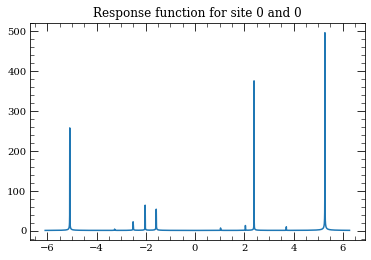

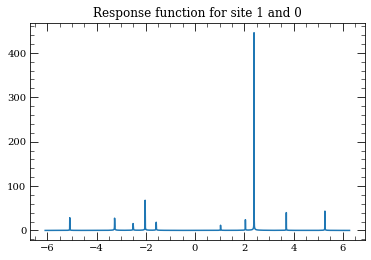

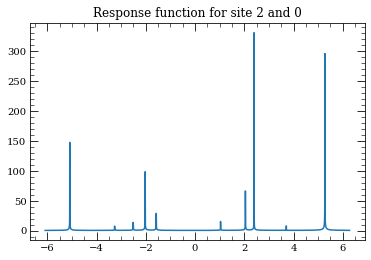

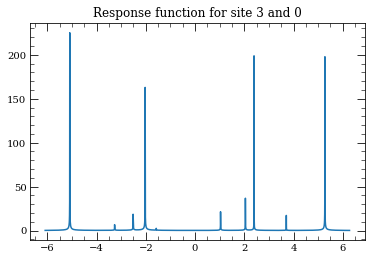

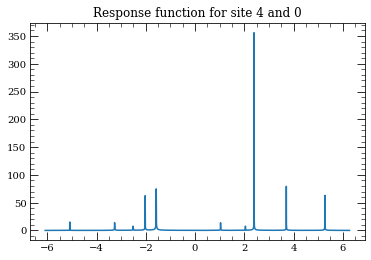

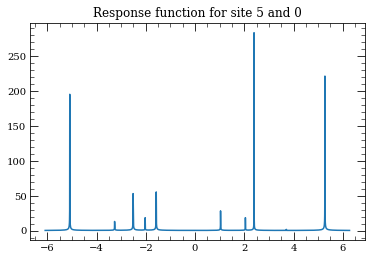

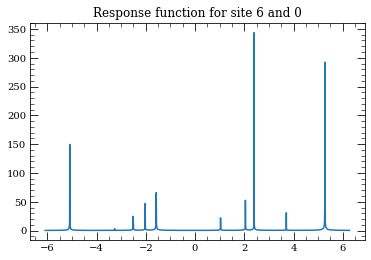

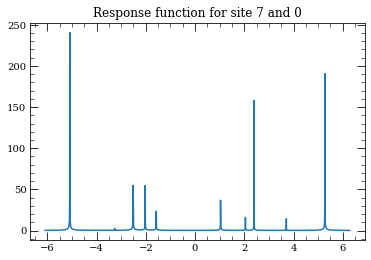

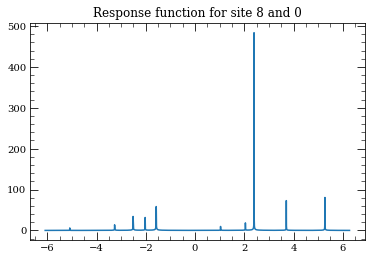

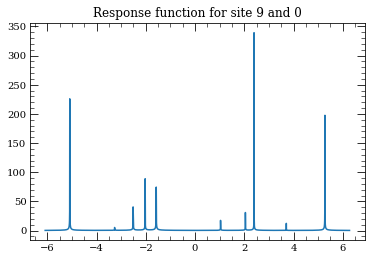

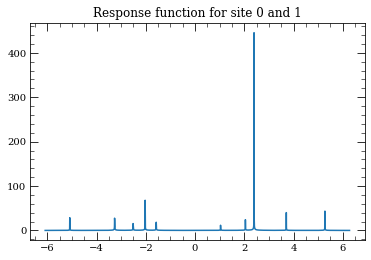

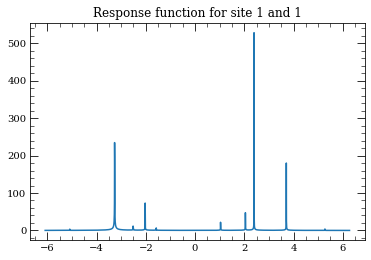

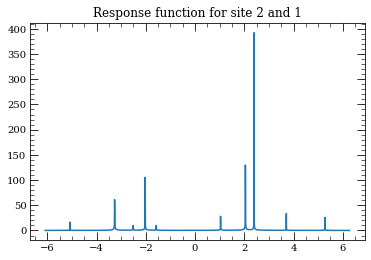

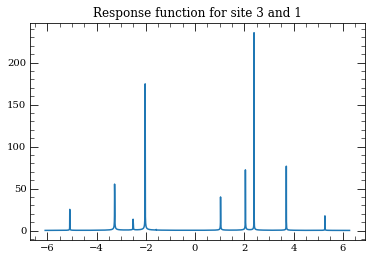

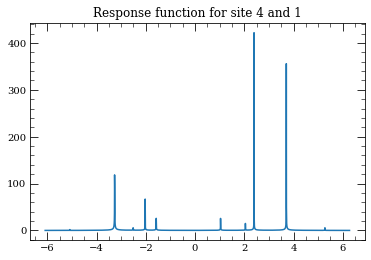

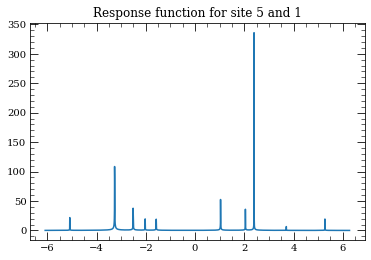

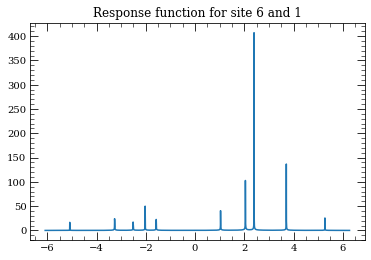

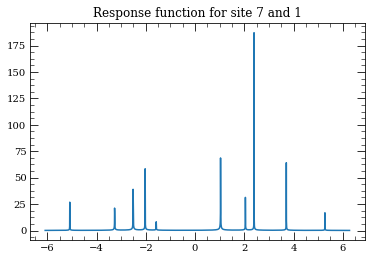

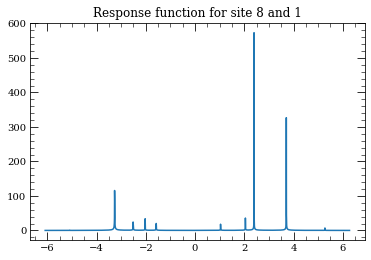

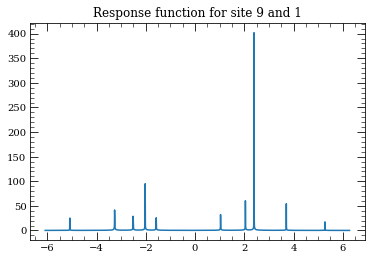

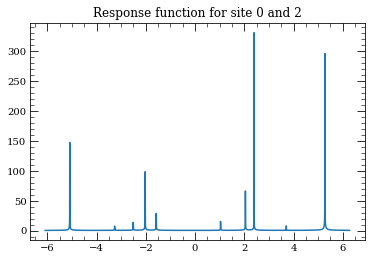

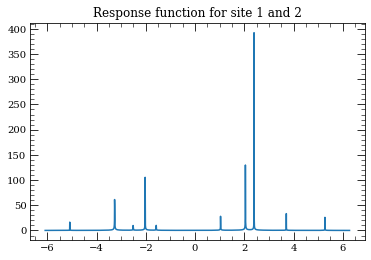

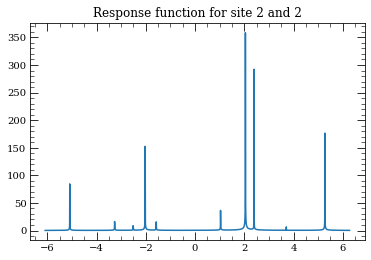

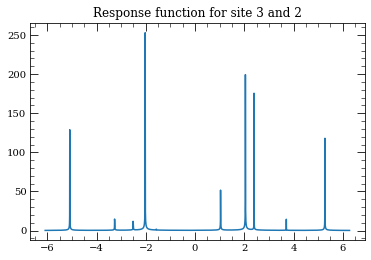

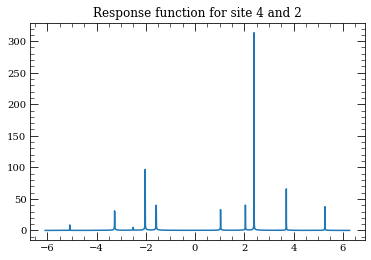

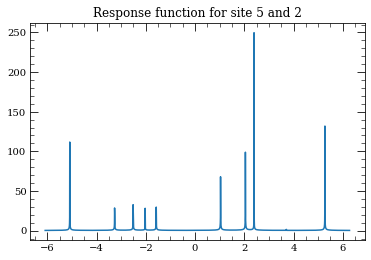

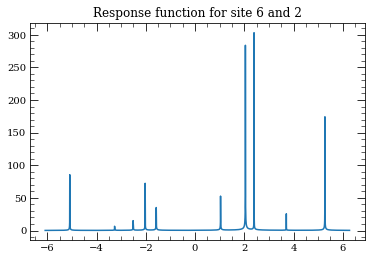

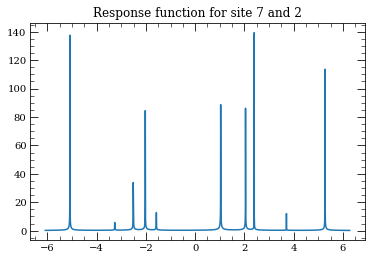

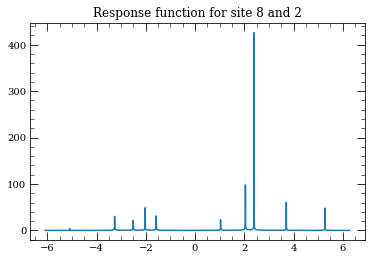

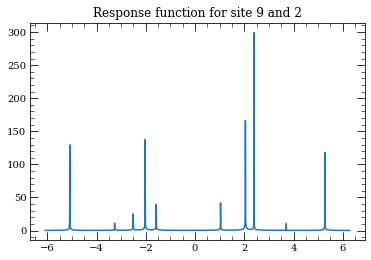

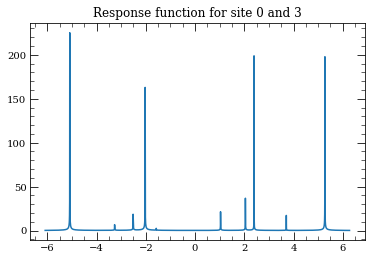

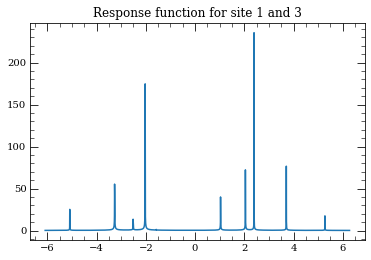

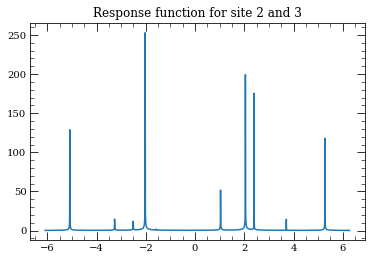

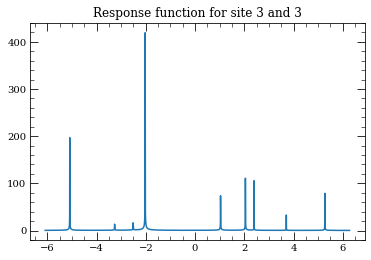

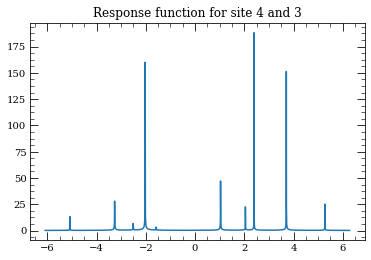

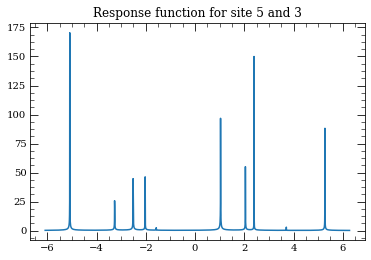

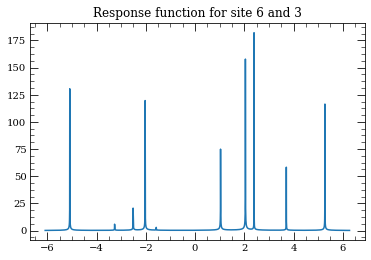

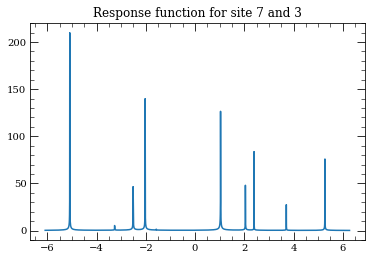

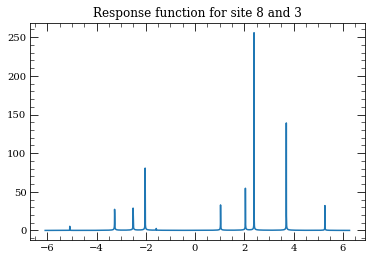

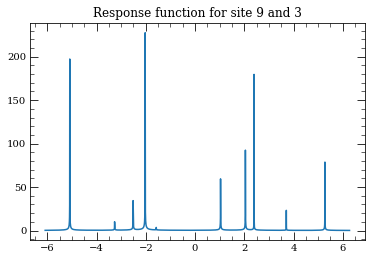

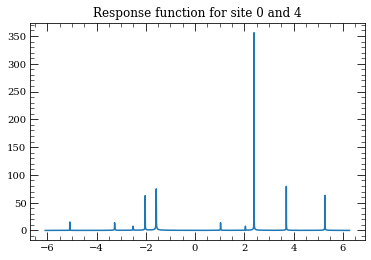

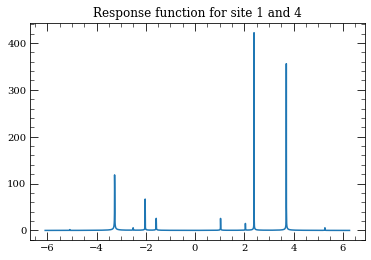

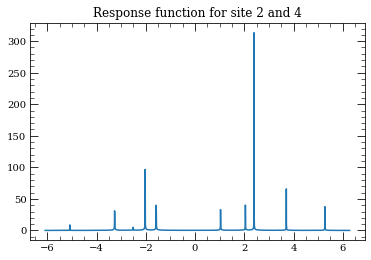

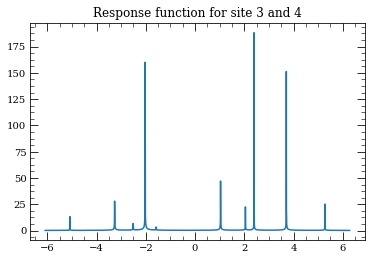

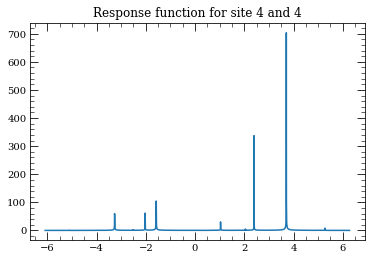

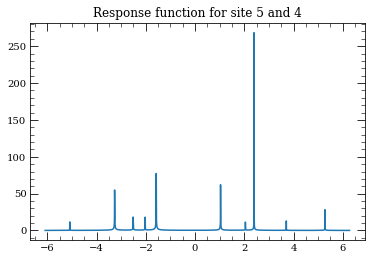

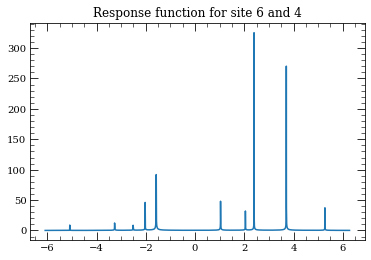

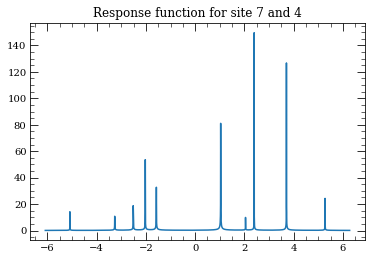

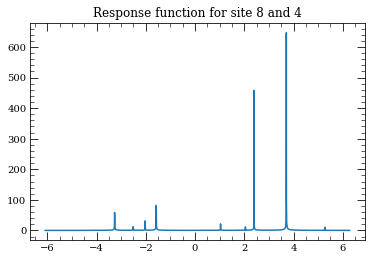

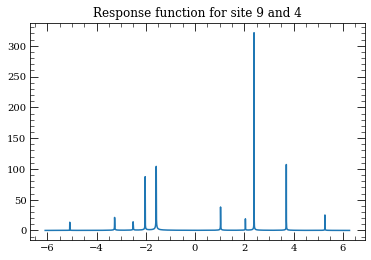

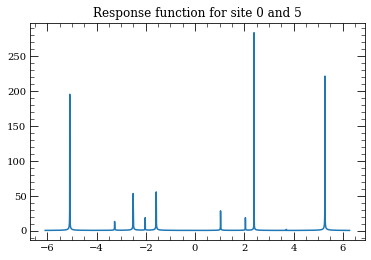

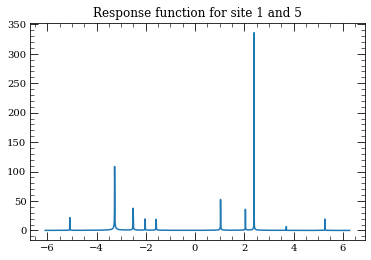

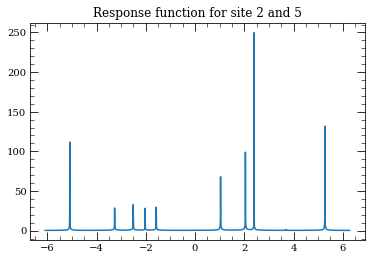

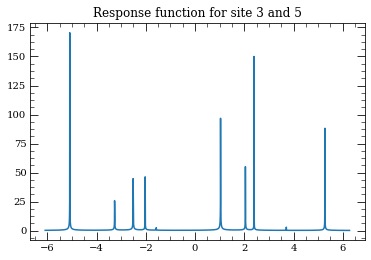

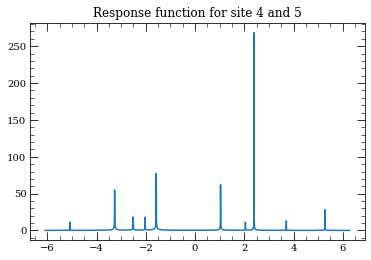

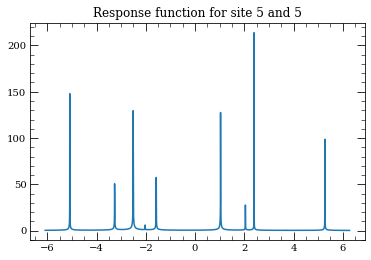

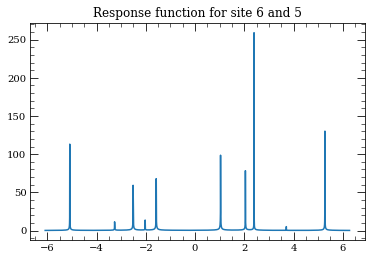

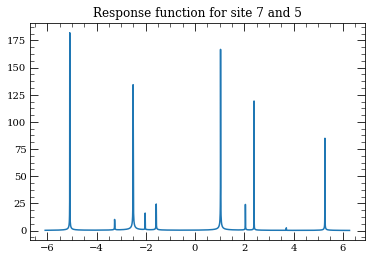

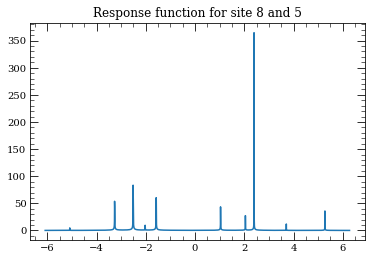

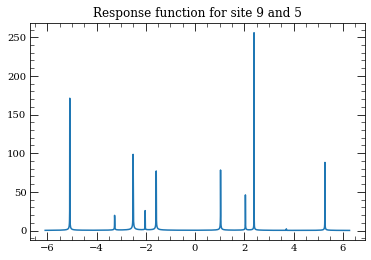

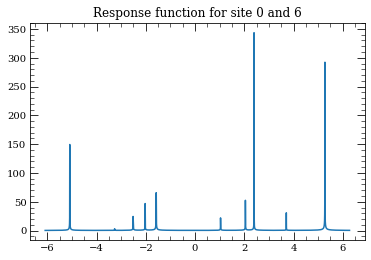

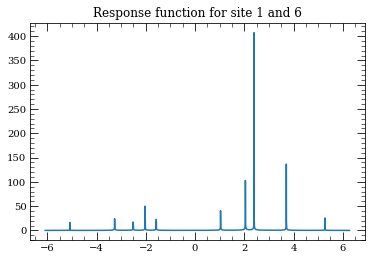

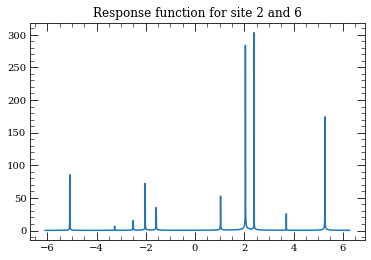

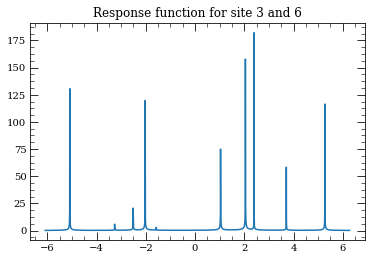

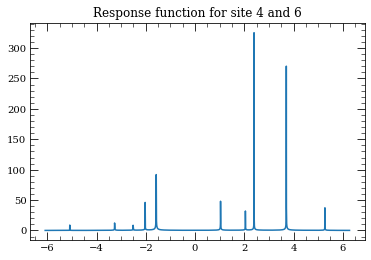

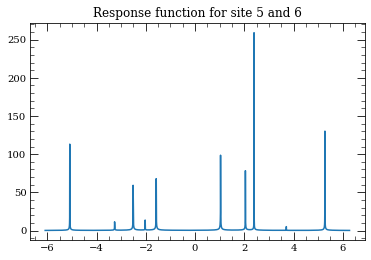

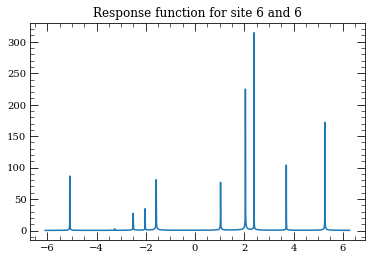

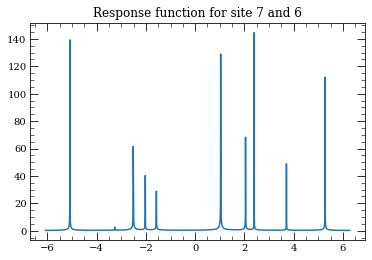

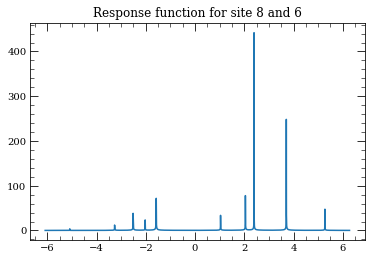

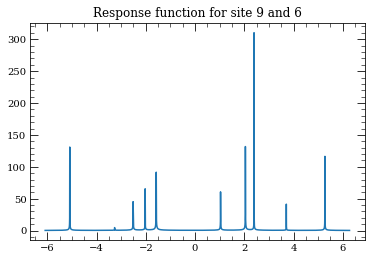

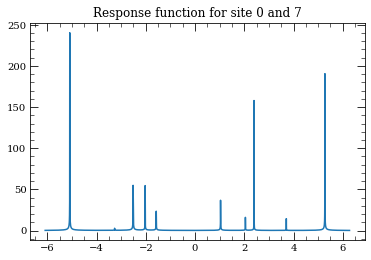

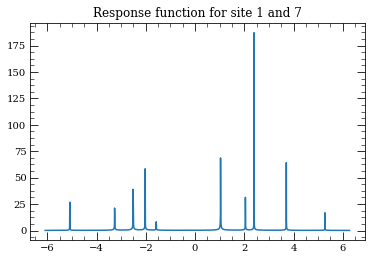

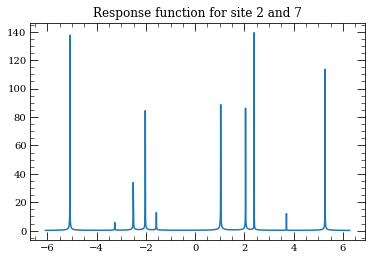

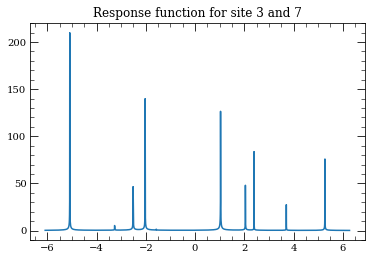

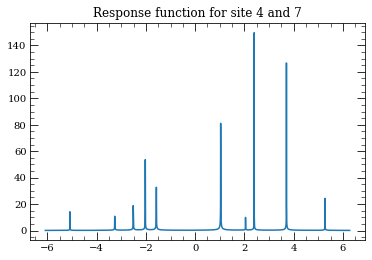

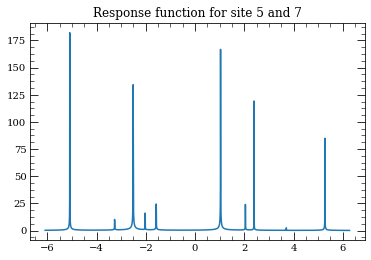

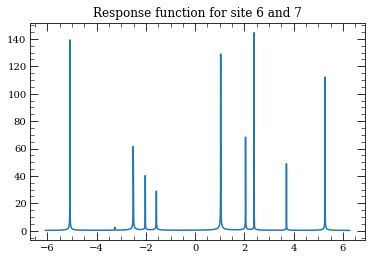

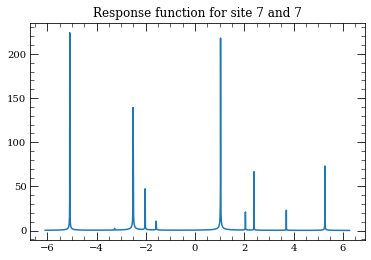

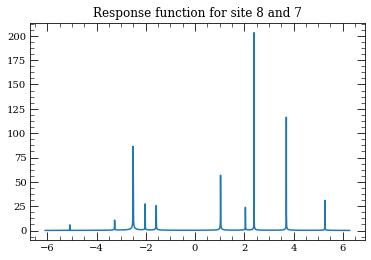

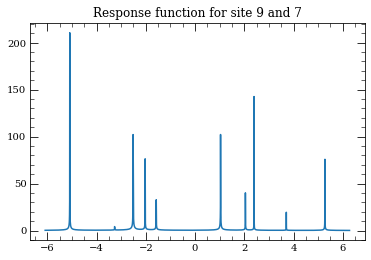

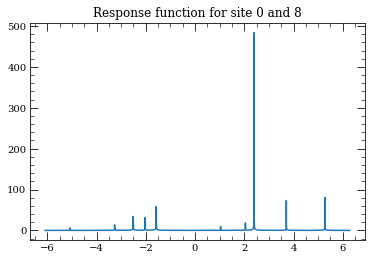

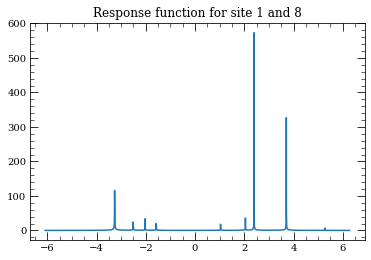

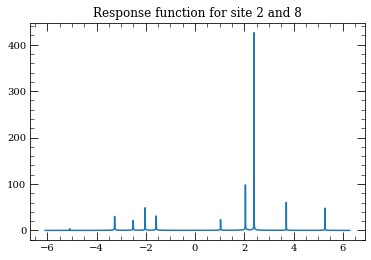

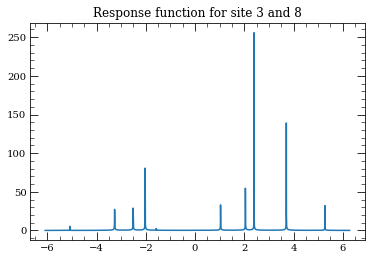

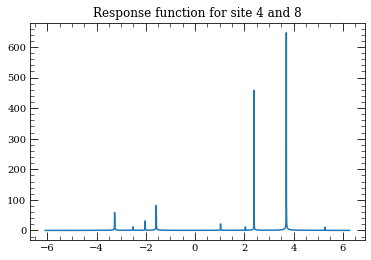

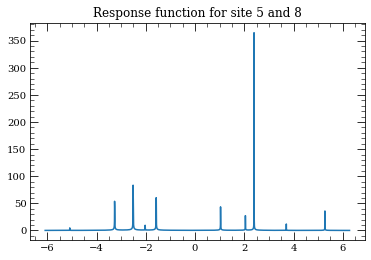

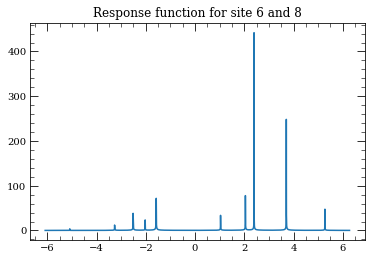

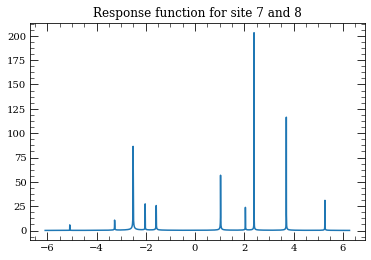

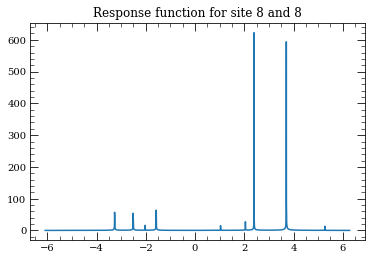

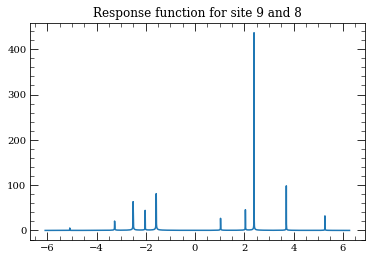

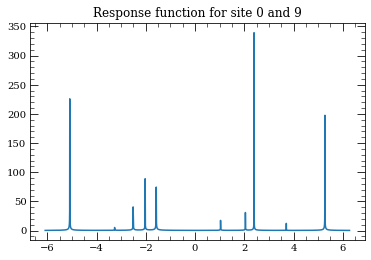

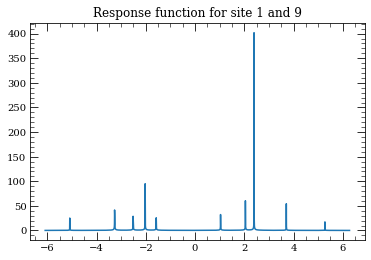

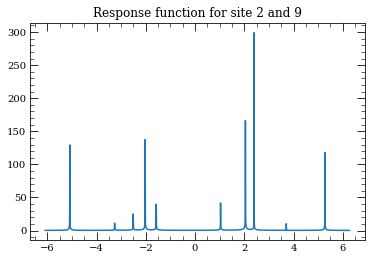

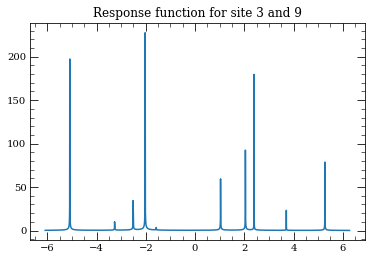

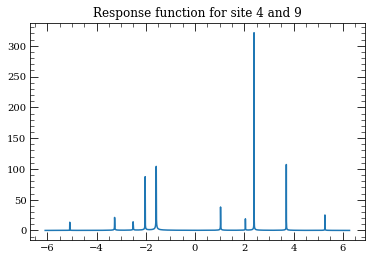

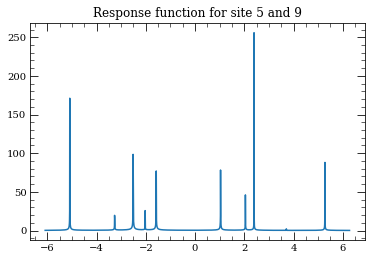

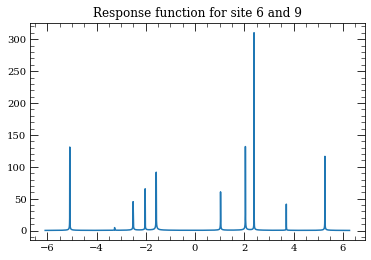

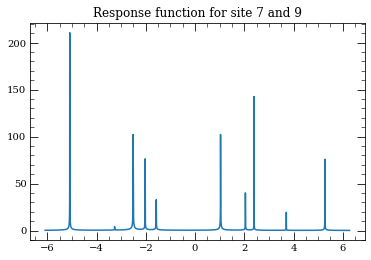

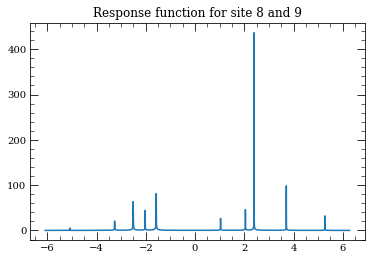

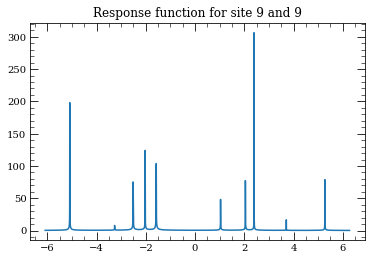

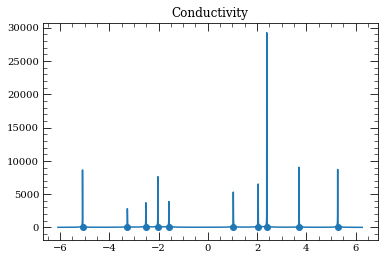

Calcing response function


In [31]:
M=1
P=-np.pi/2*1j
symm=True
sets=2
obs_basis=1
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)
runHamiltonian(site_num,1,H,proj,obs_basis)

In [196]:
symm = True
atom_sets = 2     #How many coupling pairs
w1 = 1                #The first weight
w2 = 1               #The second weight
w3 = 1

1 particle basis
2 particle basis
3 particle basis
4 particle basis
5 particle basis
6 particle basis
7 particle basis
8 particle basis
9 particle basis


<Figure size 1080x1440 with 0 Axes>

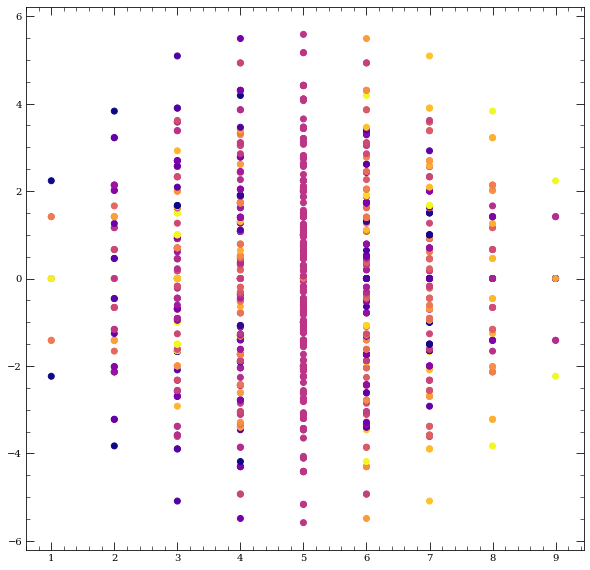

<Figure size 1080x1440 with 0 Axes>

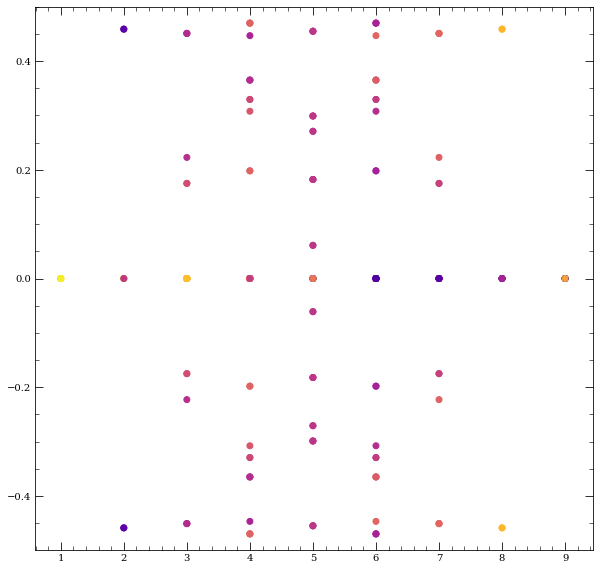

In [36]:
M=0
P=0
symm=True
sets=2
printEigenspectrum(M,P,1,1,1,symm,sets)

In [ ]:
obs_basis=2
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)
eVals,eVecs,edge=findEigenVectors(eVecs,eVals,proj,nodes,True)

1 particle basis
2 particle basis
3 particle basis
4 particle basis
5 particle basis
6 particle basis
7 particle basis
8 particle basis
9 particle basis


<Figure size 1080x1440 with 0 Axes>

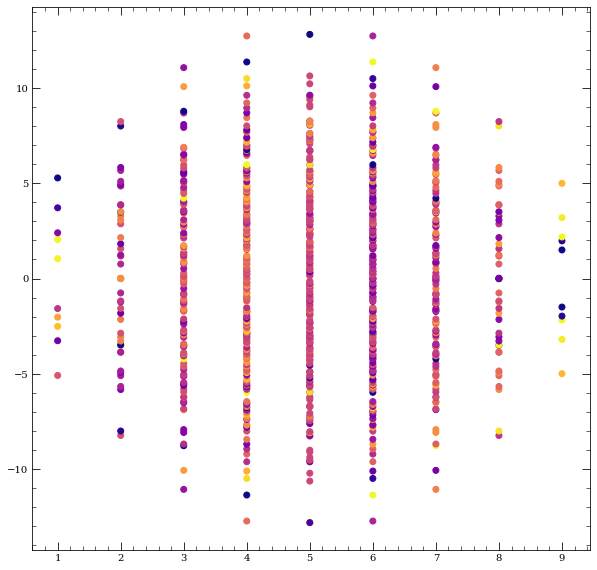

<Figure size 1080x1440 with 0 Axes>

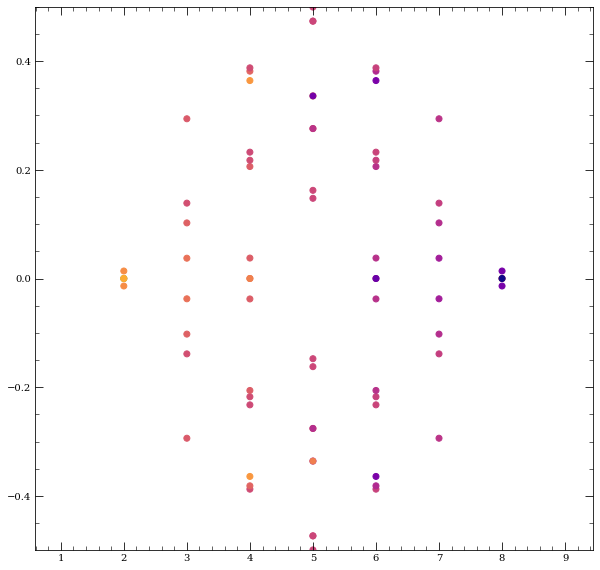

In [34]:
M=1
P=-np.pi/2*1j
symm=True
sets=2
printEigenspectrum(M,P,1,1,1,symm,sets)

-5.086029713428715


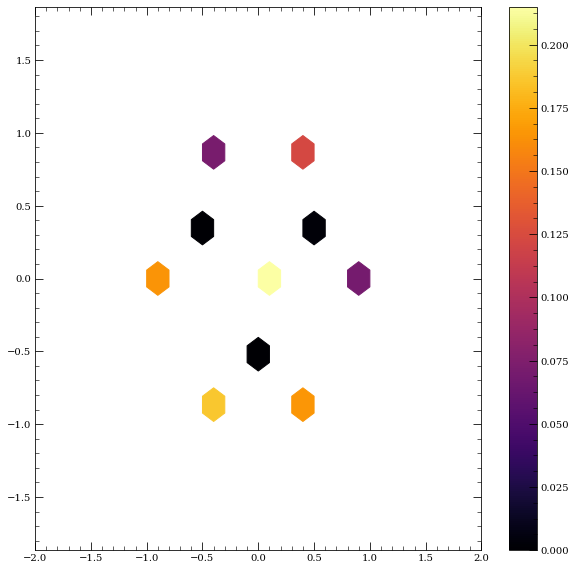

-3.264340807967643


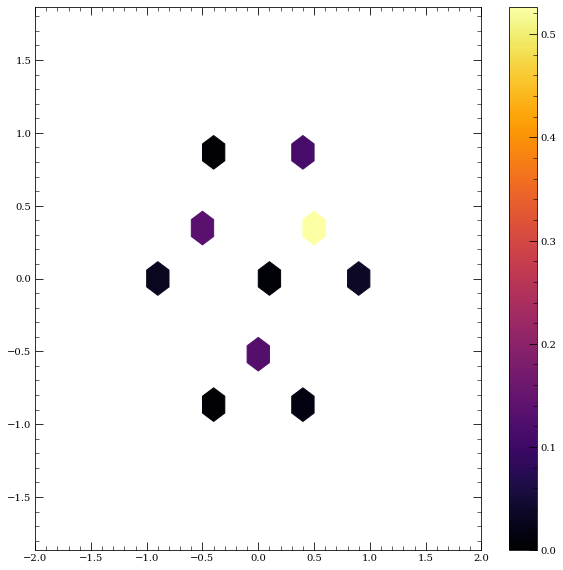

-2.5126579632016575


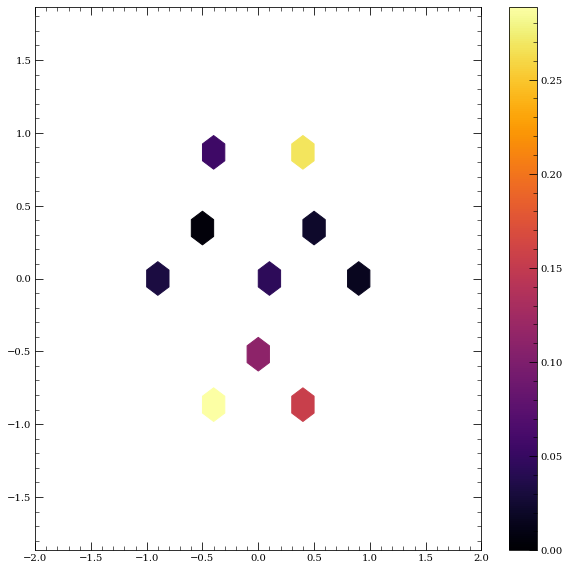

-2.026043545111885


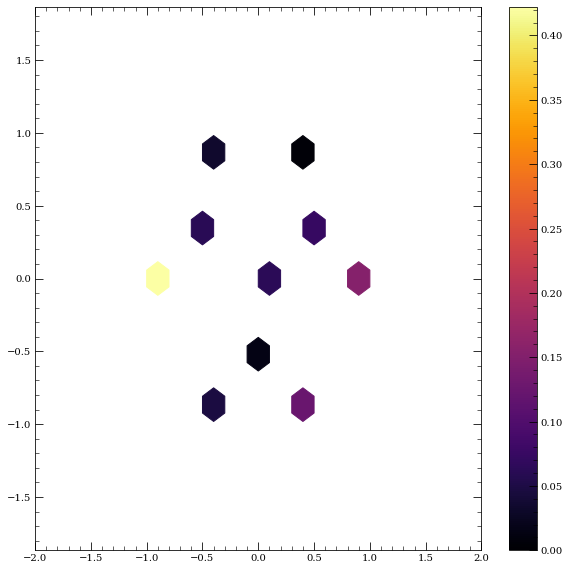

-1.5769429192258144


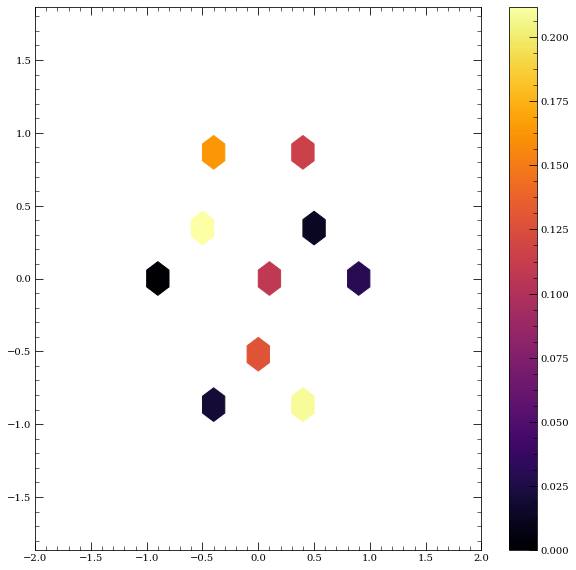

1.0383110686010886


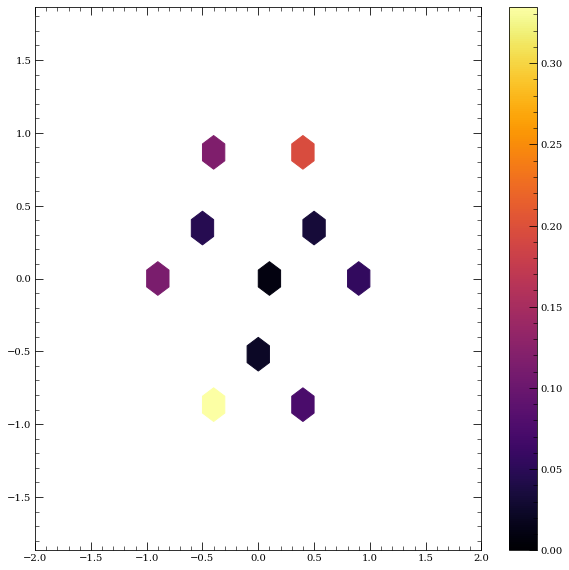

2.046939309624225


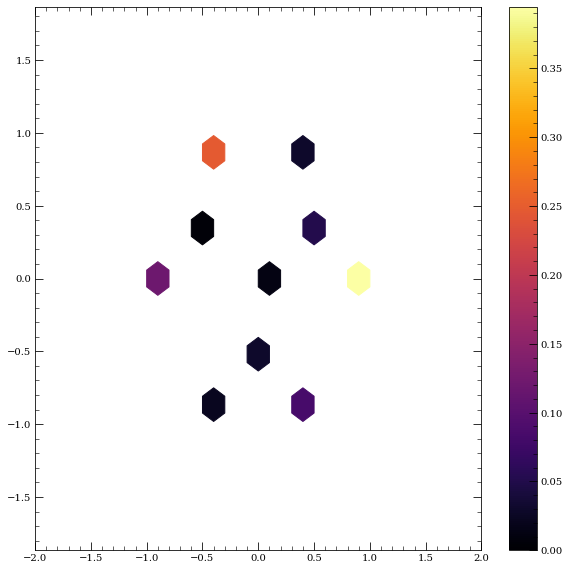

2.397335870884821


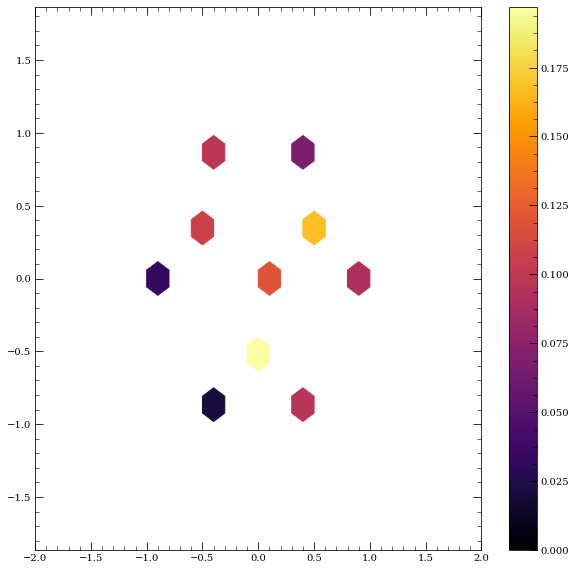

3.7084209496531697


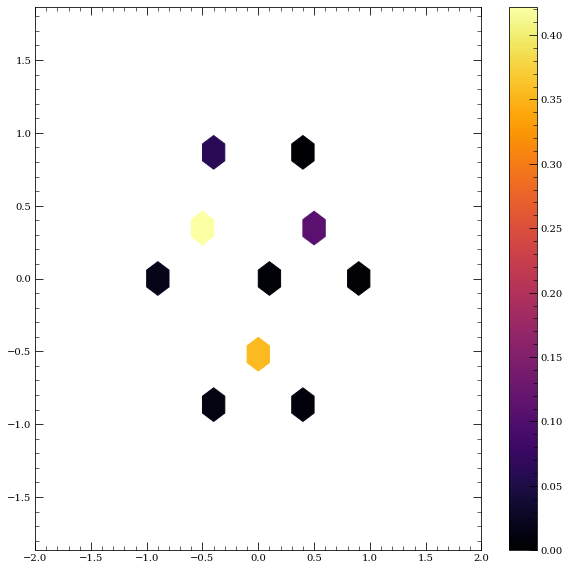

5.2750077501723736


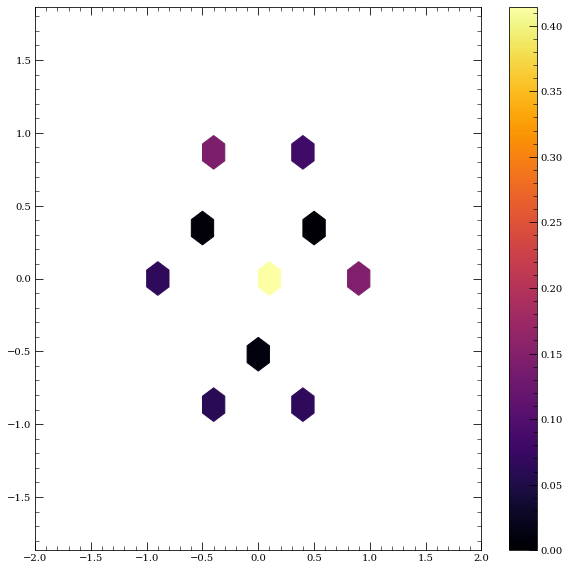

In [32]:
obs_basis=1
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)
eVals,eVecs,edge=findEigenVectors(eVecs,eVals,proj,nodes,True)

1 particle basis
2 particle basis
3 particle basis
4 particle basis
5 particle basis
6 particle basis
7 particle basis
8 particle basis
9 particle basis


<Figure size 1080x1440 with 0 Axes>

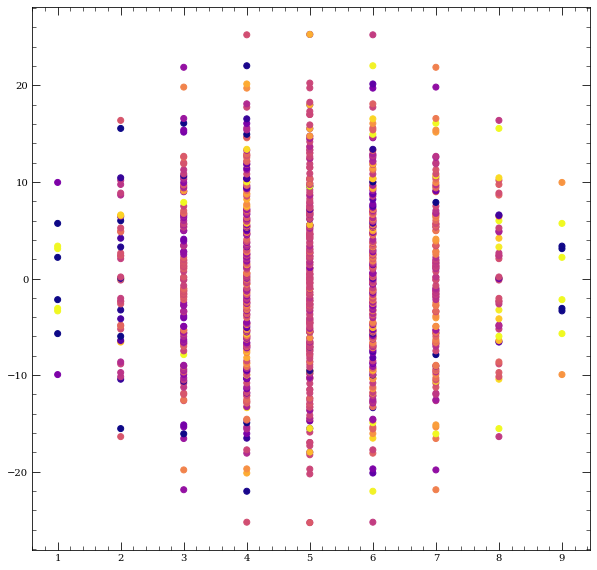

<Figure size 1080x1440 with 0 Axes>

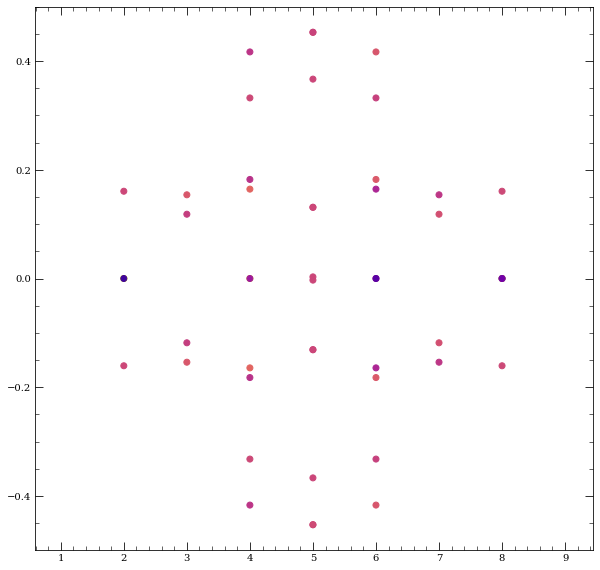

In [17]:
M=0
P=np.pi*1j
symm=True
sets=2
printEigenspectrum(M,P,1,1,1,symm,sets)

-9.945161901483253


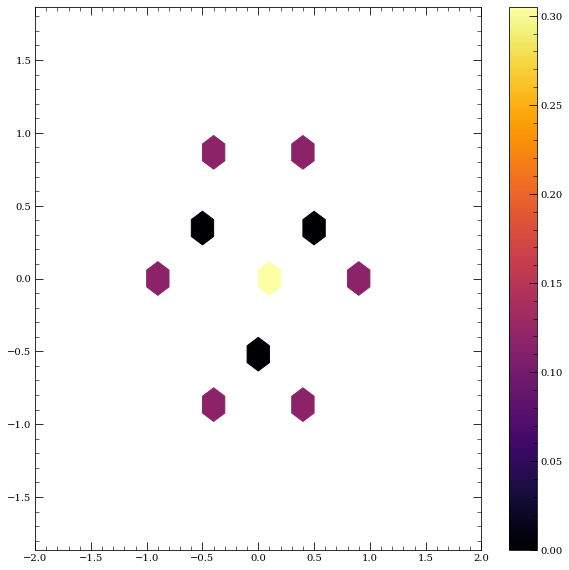

-5.704611098389801


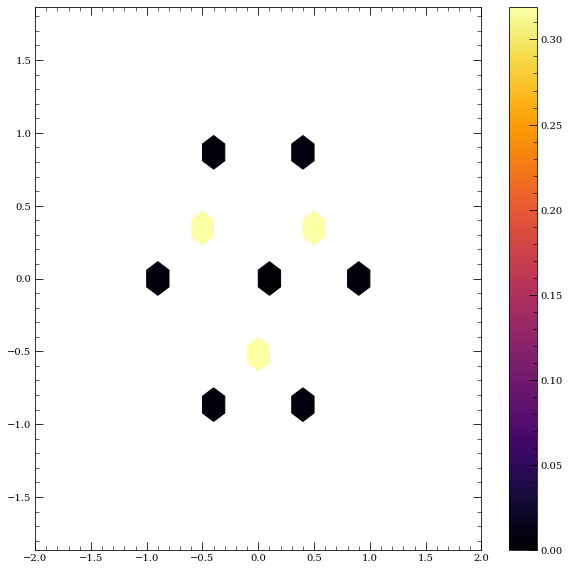

-3.3542446828440227


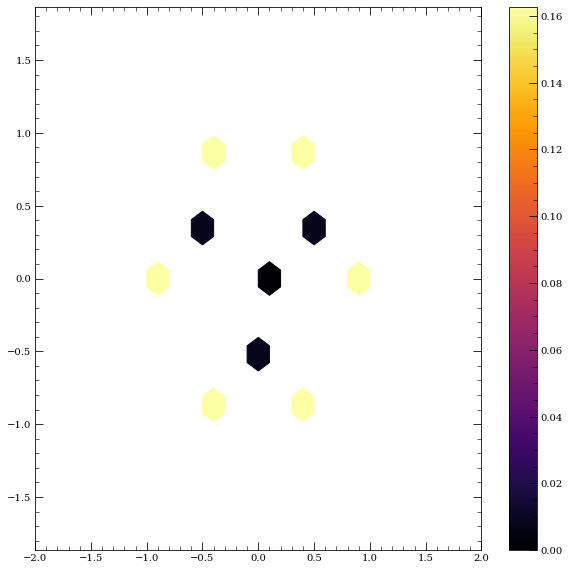

-3.0910316771568755


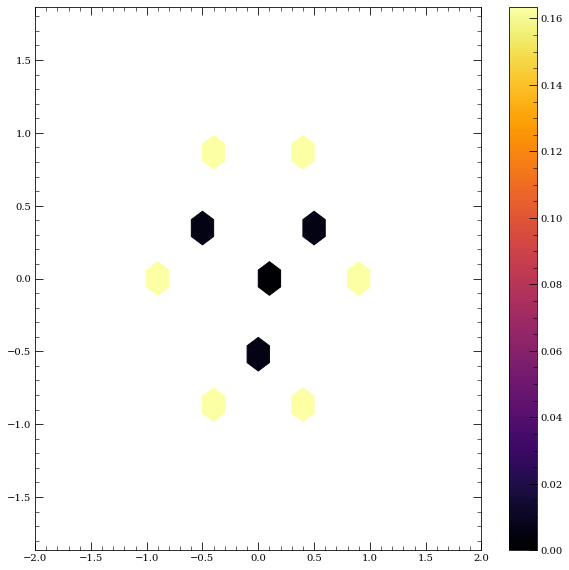

-2.1885608888442913


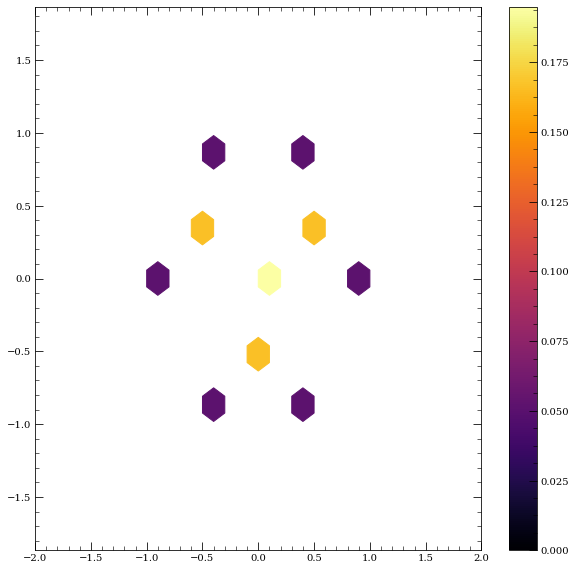

2.188560888844295


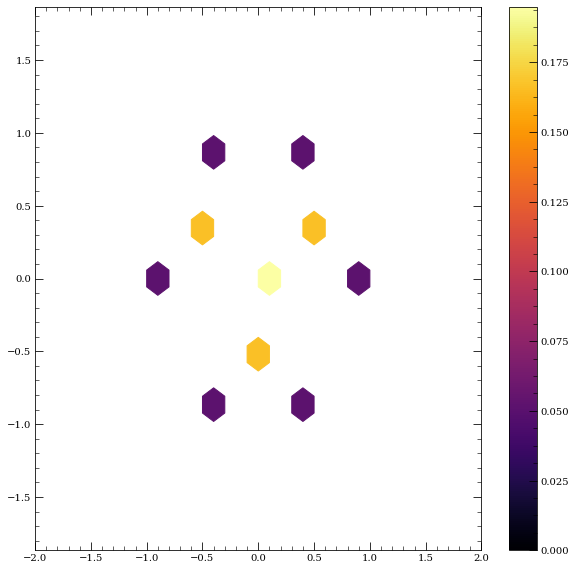

3.0910316771568898


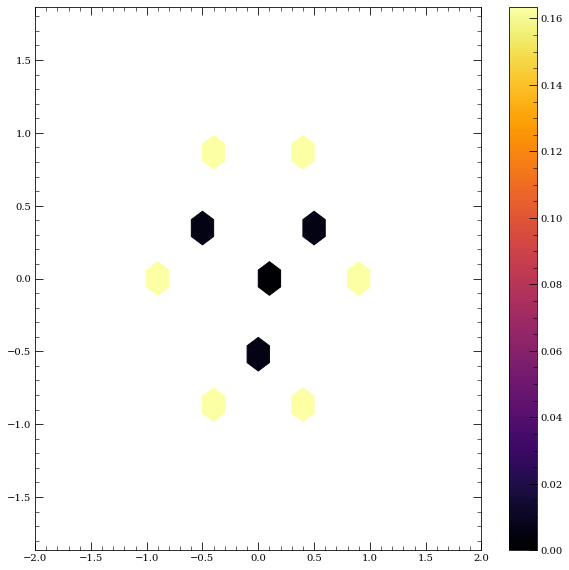

3.354244682844037


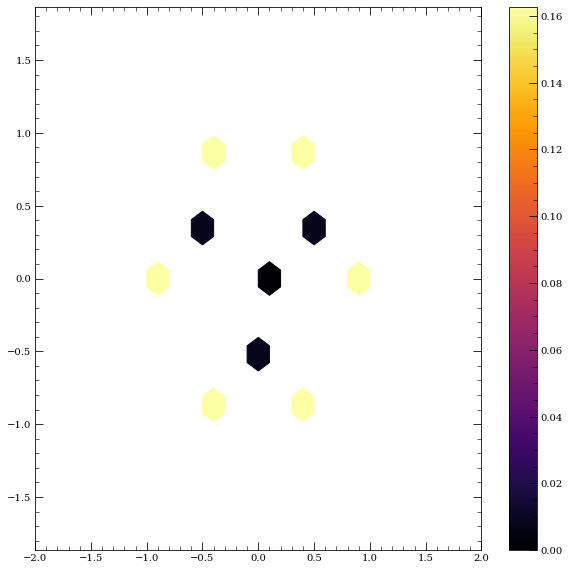

5.7046110983898


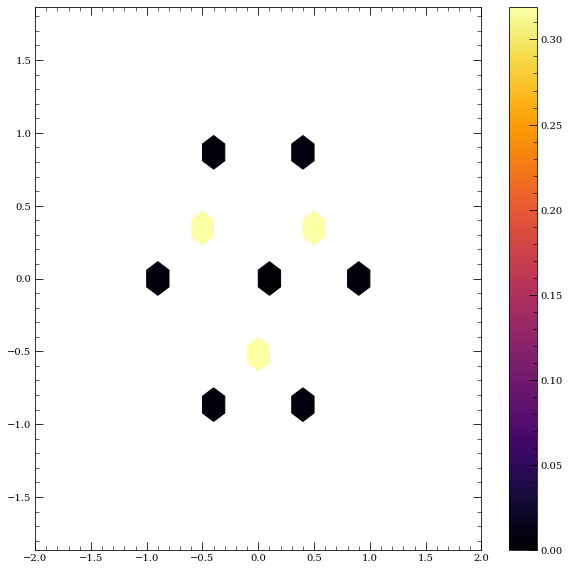

9.945161901483289


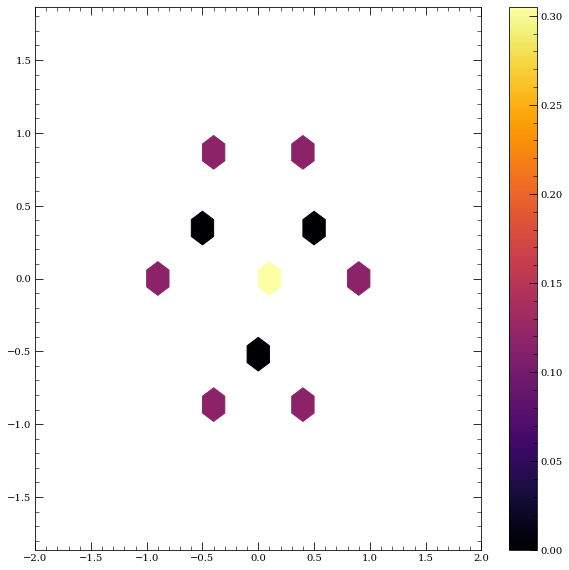

In [18]:
obs_basis=1
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)
eVals,eVecs,edge=findEigenVectors(eVecs,eVals,proj,nodes,True)

1 particle basis
2 particle basis
3 particle basis
4 particle basis
5 particle basis
6 particle basis
7 particle basis
8 particle basis
9 particle basis


<Figure size 1080x1440 with 0 Axes>

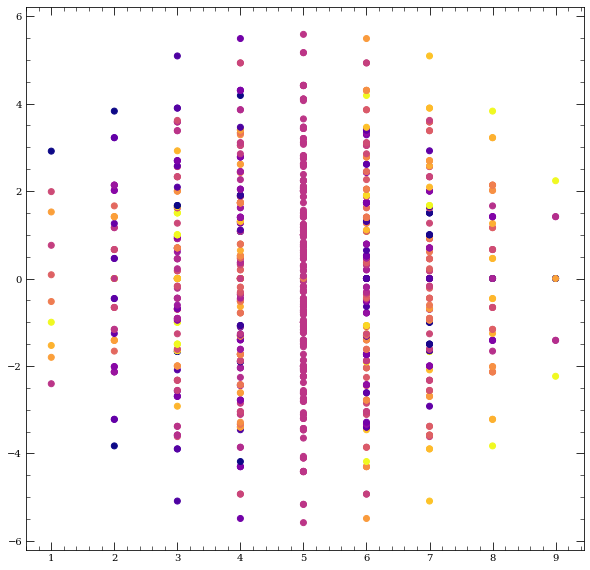

<Figure size 1080x1440 with 0 Axes>

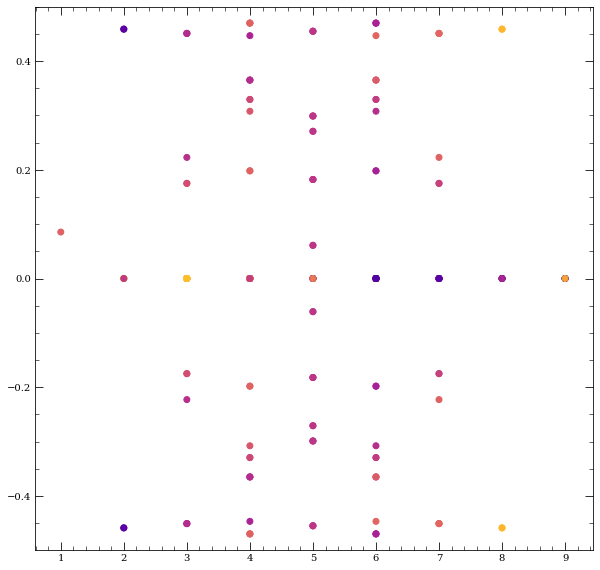

In [12]:
M=1
P=0
symm=True
sets=2
printEigenspectrum(M,P,1,1,1,symm,sets)

-3.8287151965166077


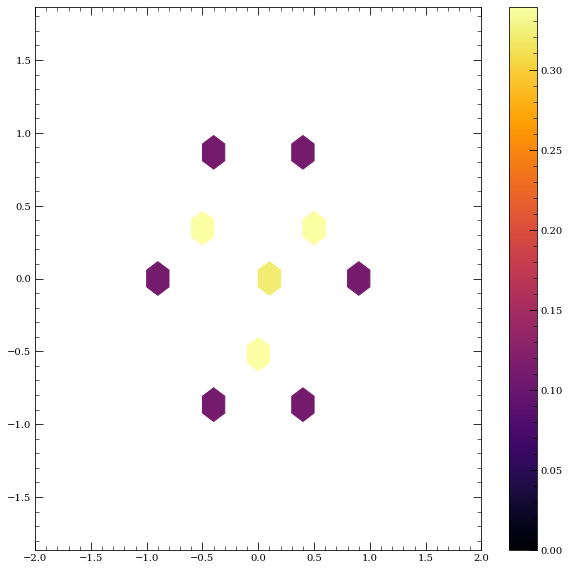

-3.220876918423111


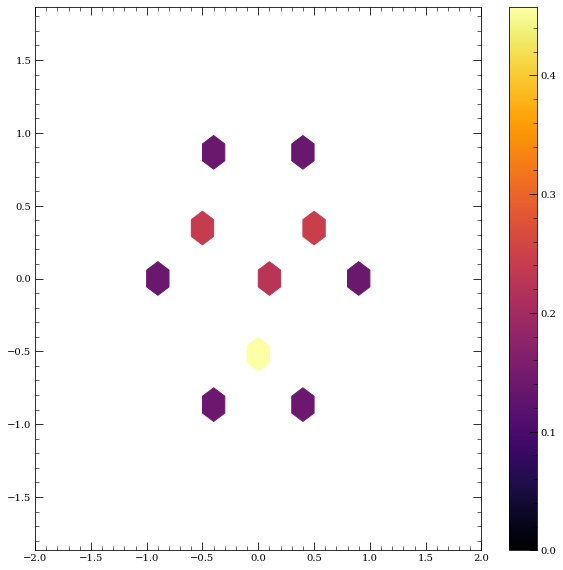

-3.2208769184231025


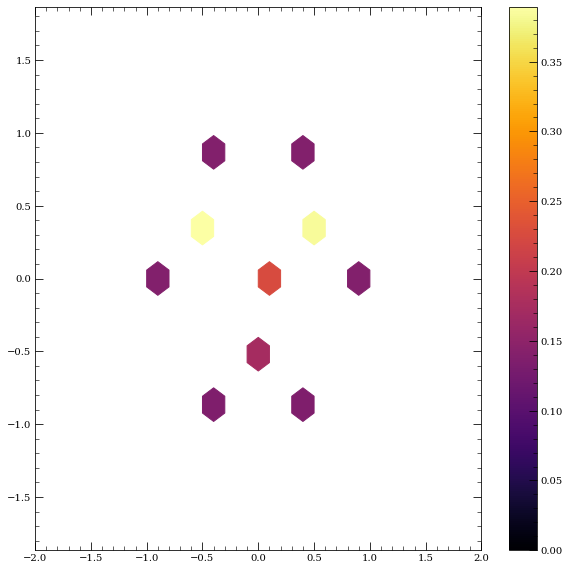

-2.135779205069858


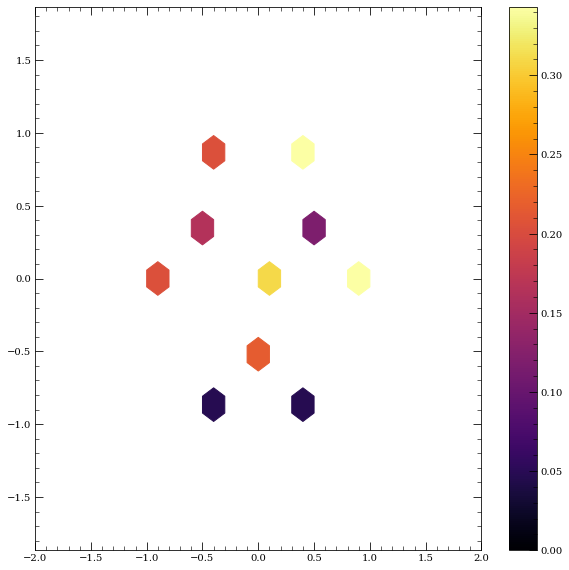

-2.1357792050698534


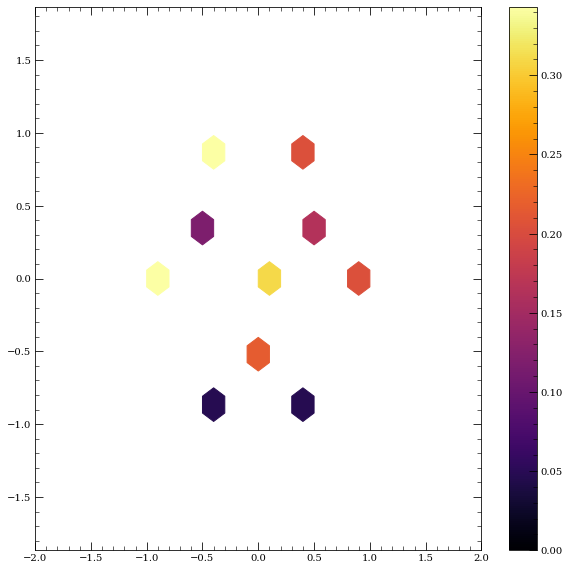

-2.1357792050698485


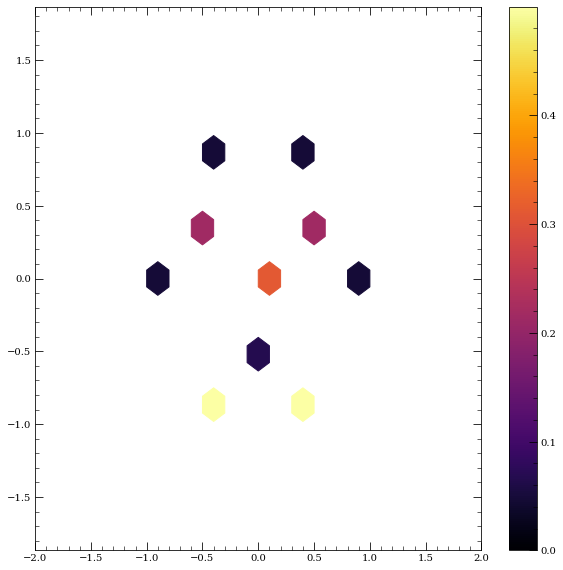

-2.01557920428876


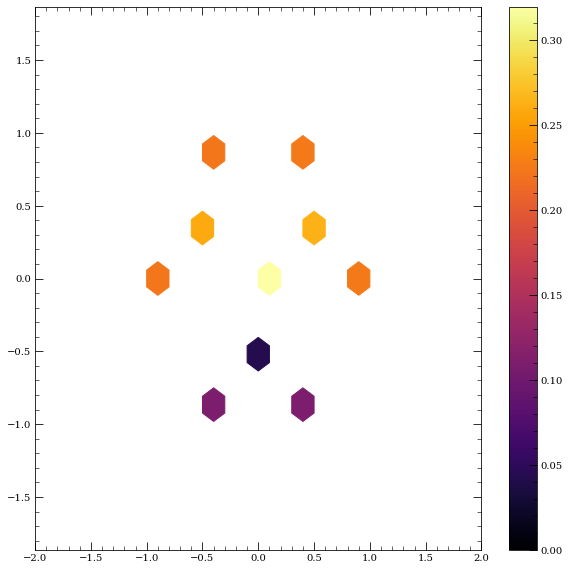

-2.0155792042887537


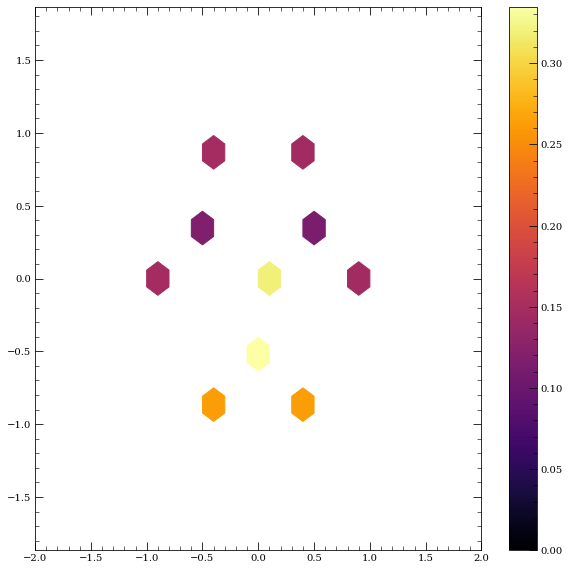

-1.6606837081188632


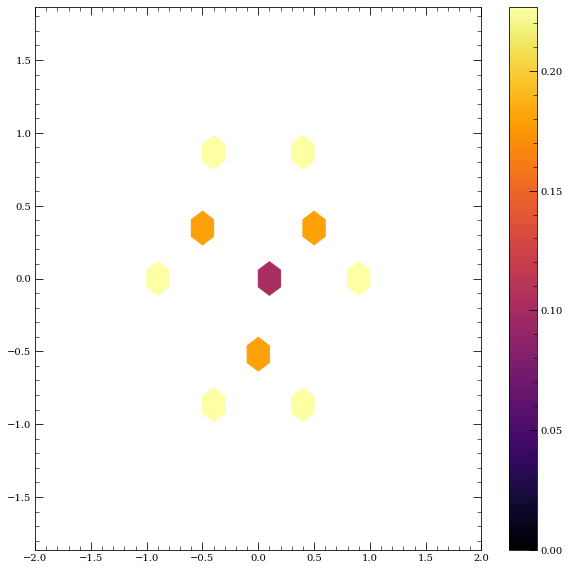

-1.4142135623730965


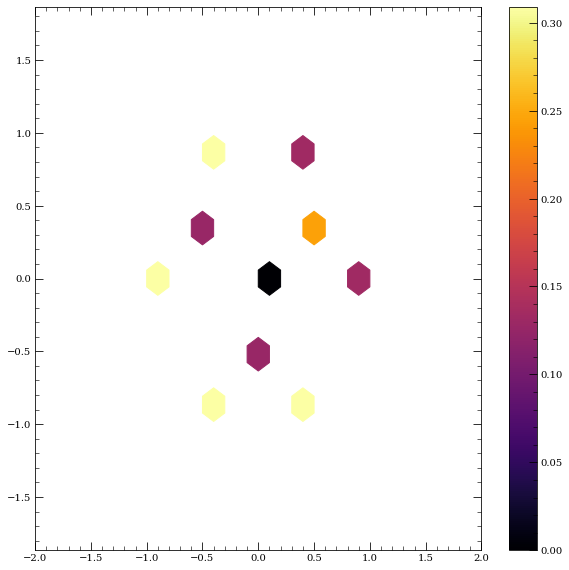

-1.4142135623730951


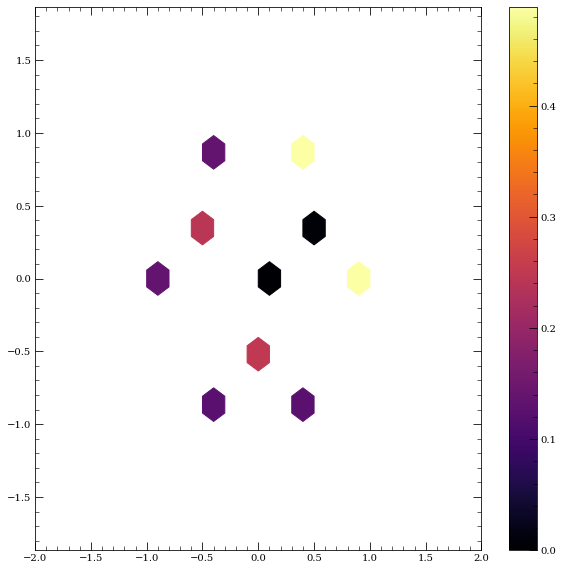

-1.4142135623730887


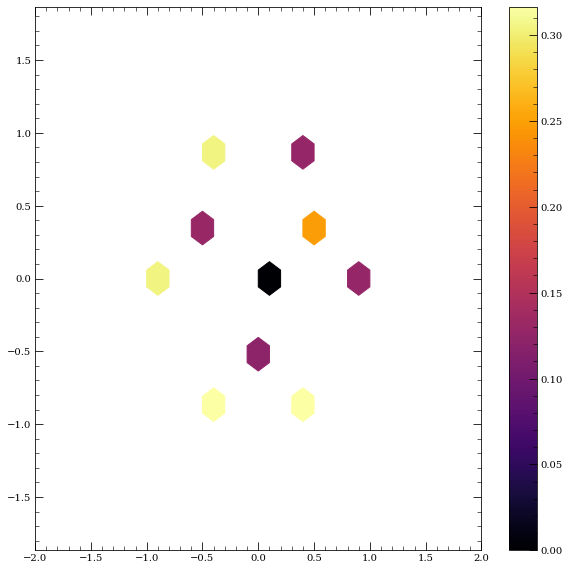

-1.2582009241577228


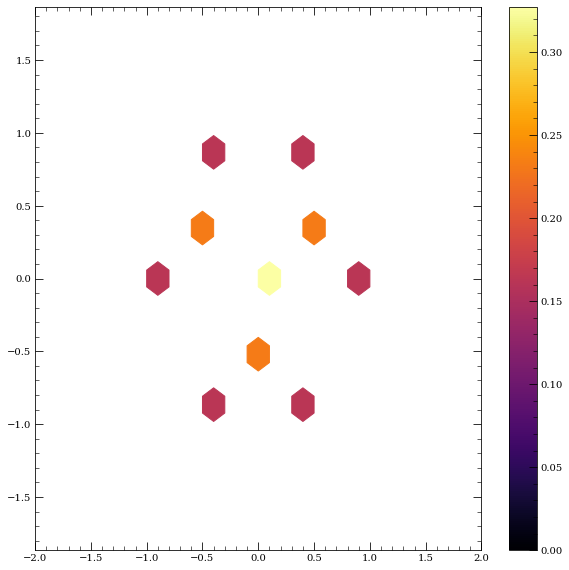

-1.163159258892663


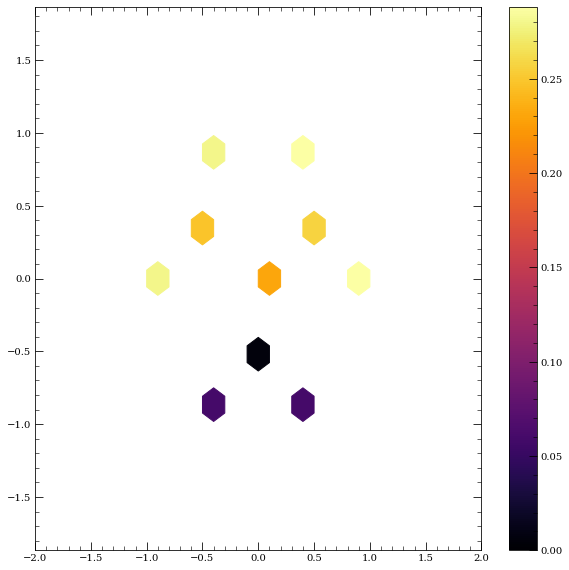

-1.1631592588926563


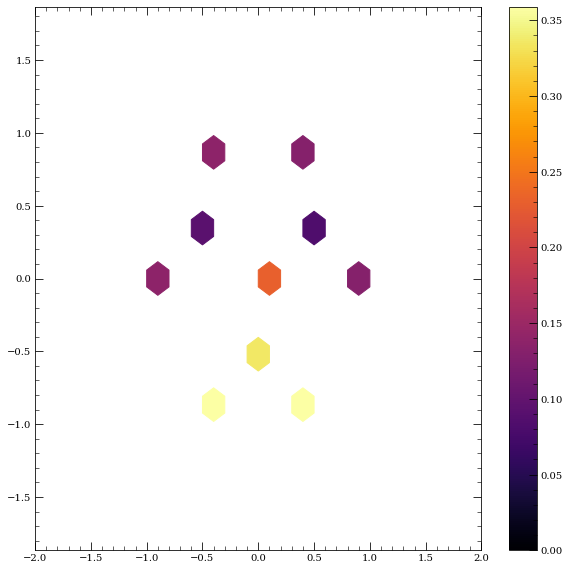

-0.6621534468619567


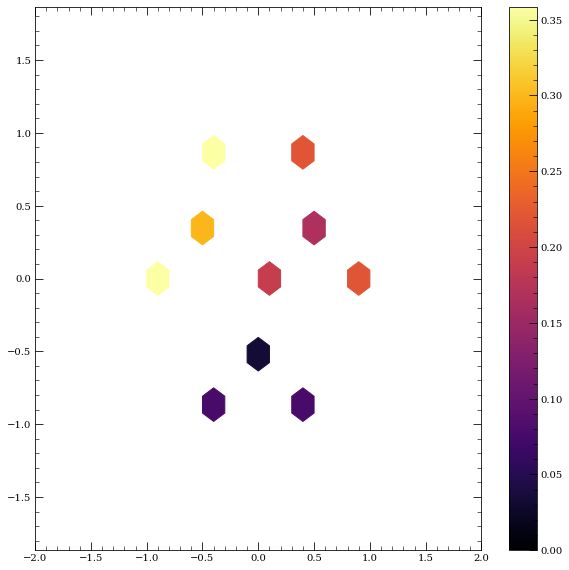

-0.6621534468619534


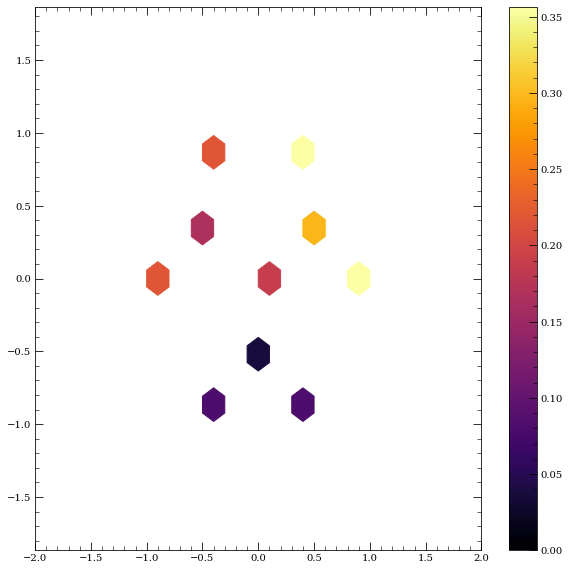

-0.6621534468619525


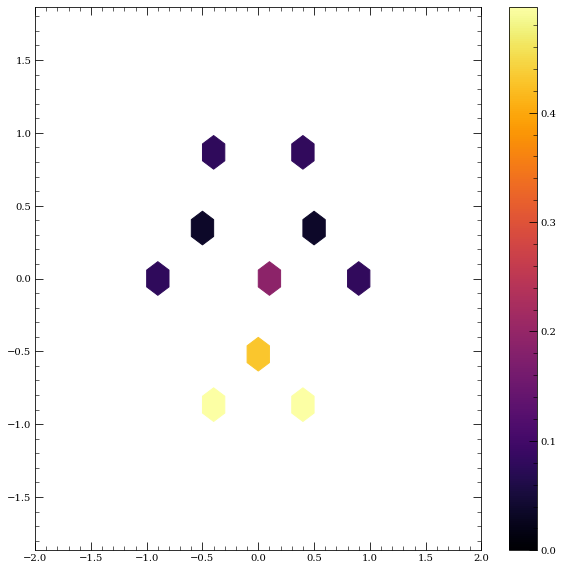

-0.4587514425701806


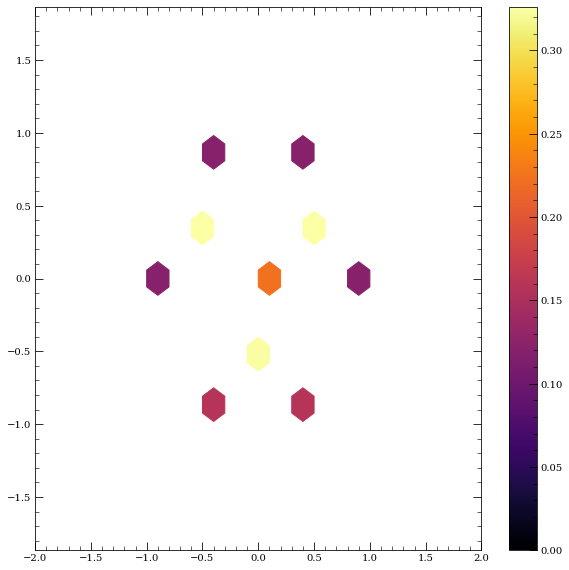

-0.45875144257017725


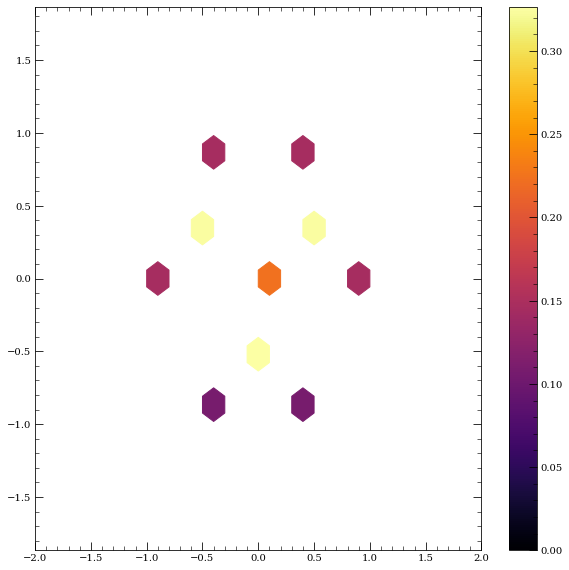

-1.7553332585808065e-16


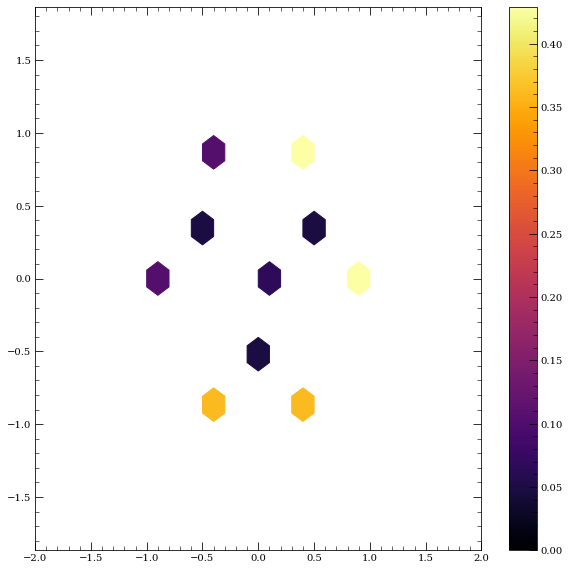

-7.103118882406812e-17


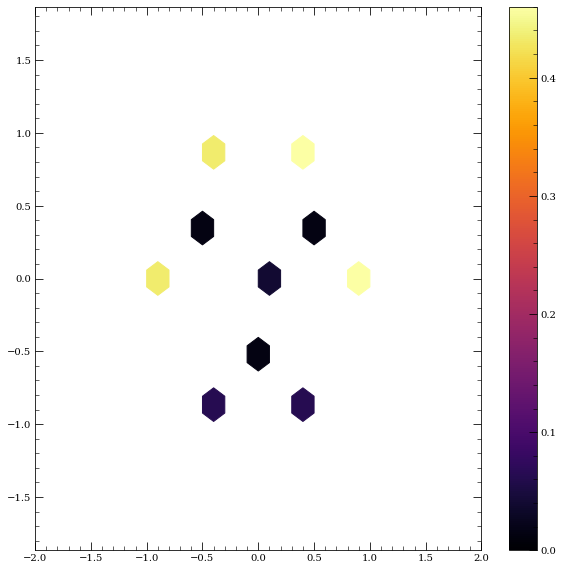

-1.0453036459140484e-17


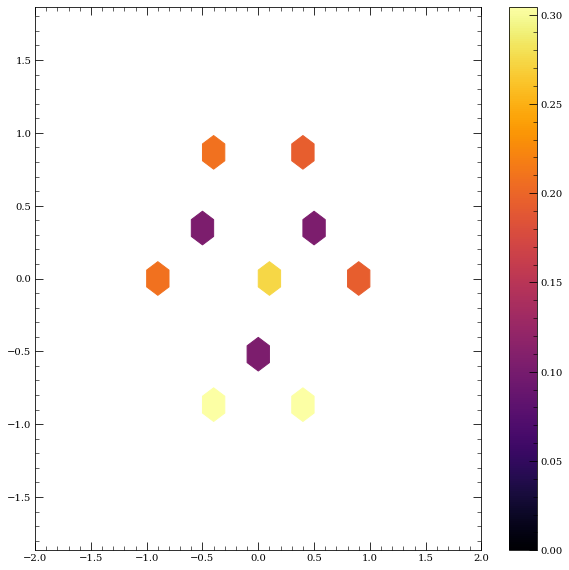

4.0810005826651253e-16


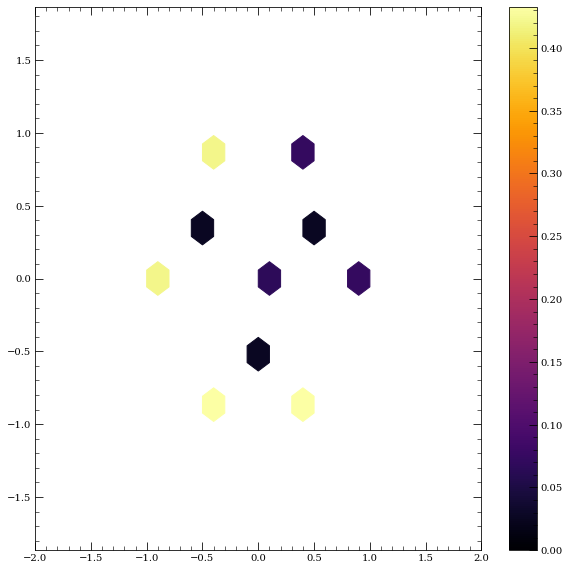

3.516326536847299e-15


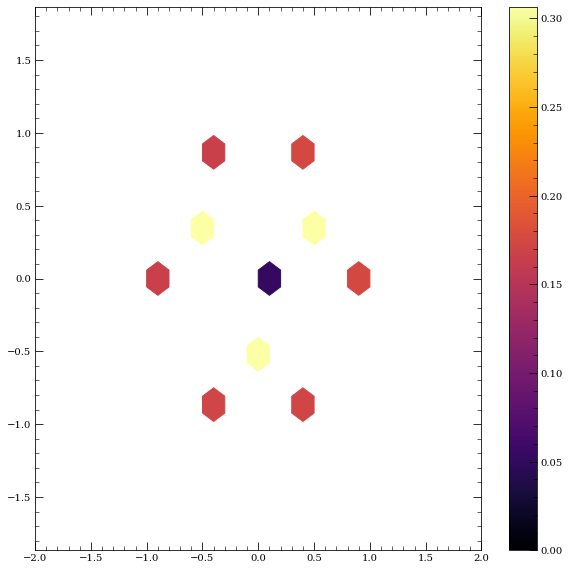

0.4587514425701753


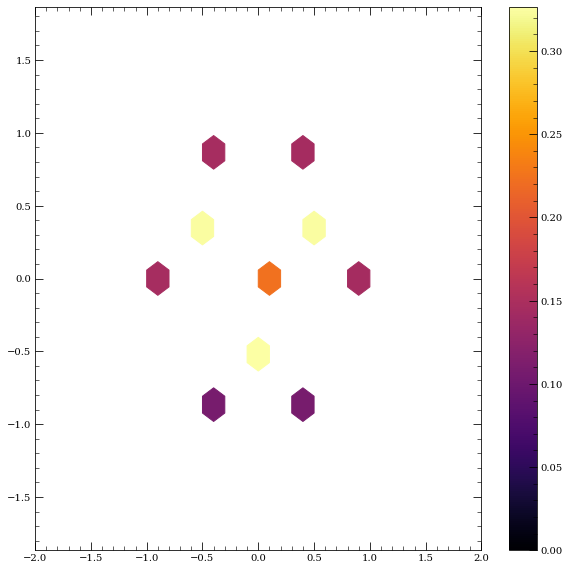

0.4587514425701812


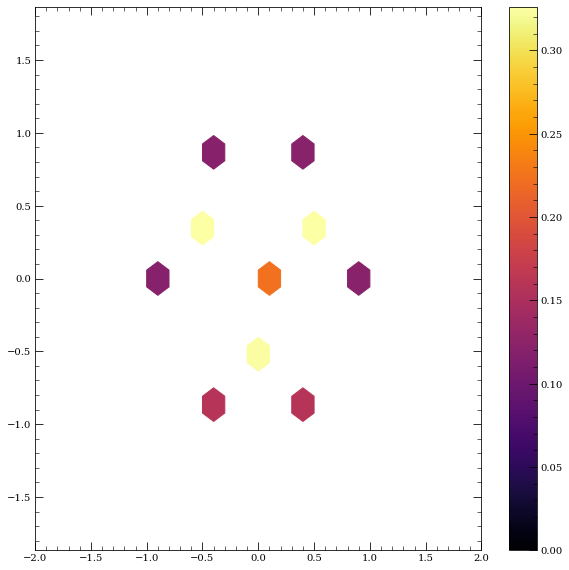

0.6621534468619578


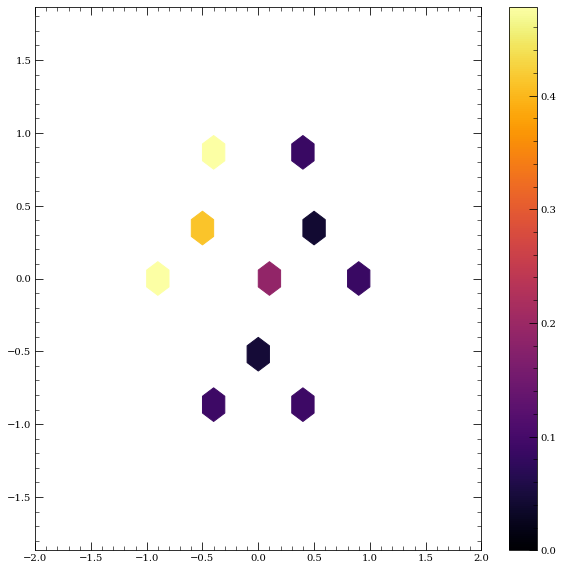

0.6621534468619579


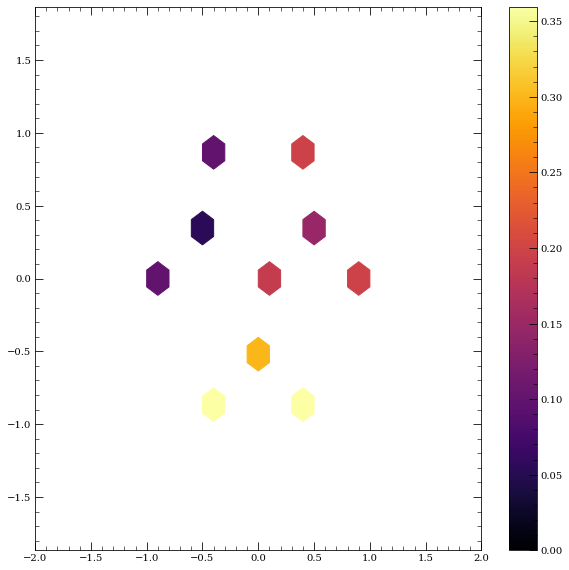

0.662153446861958


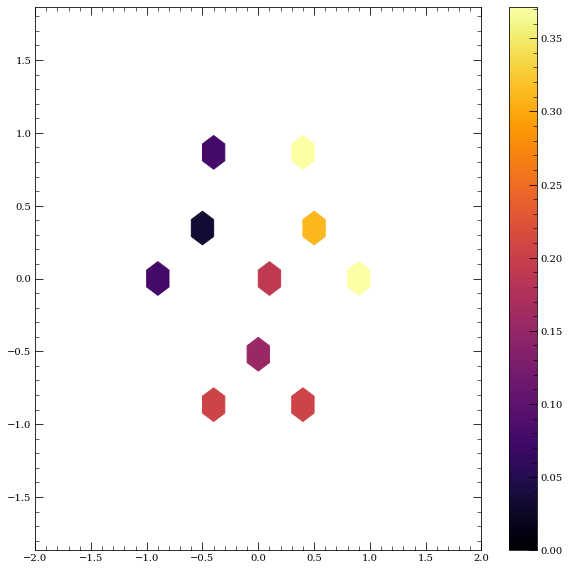

1.163159258892658


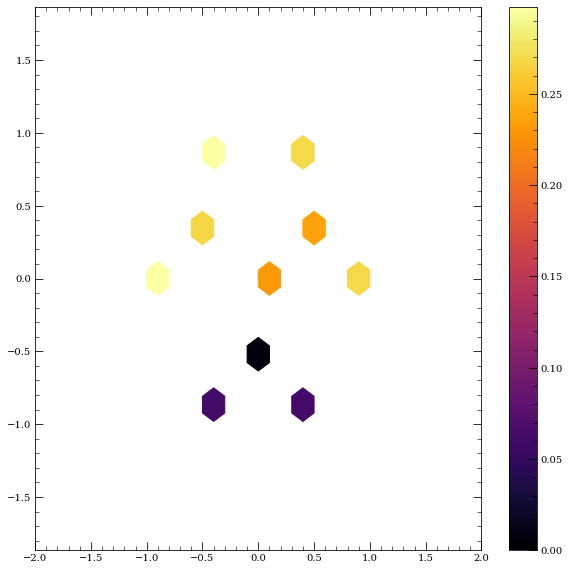

1.1631592588926616


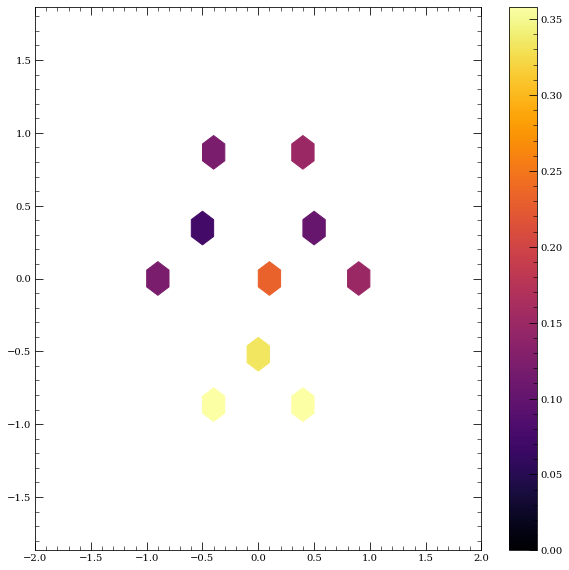

1.2582009241577192


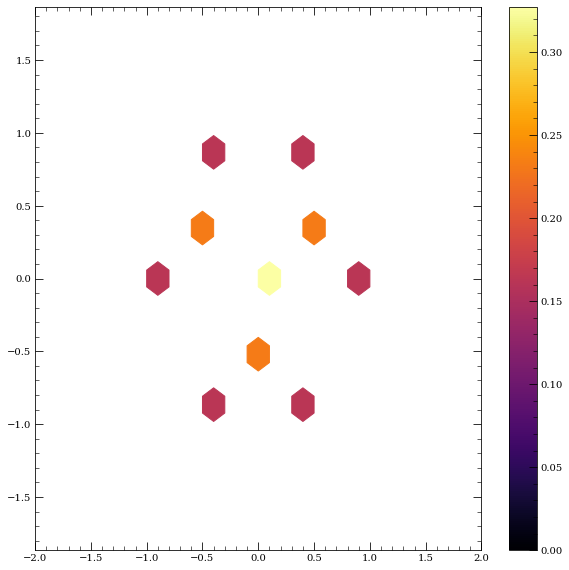

1.414213562373095


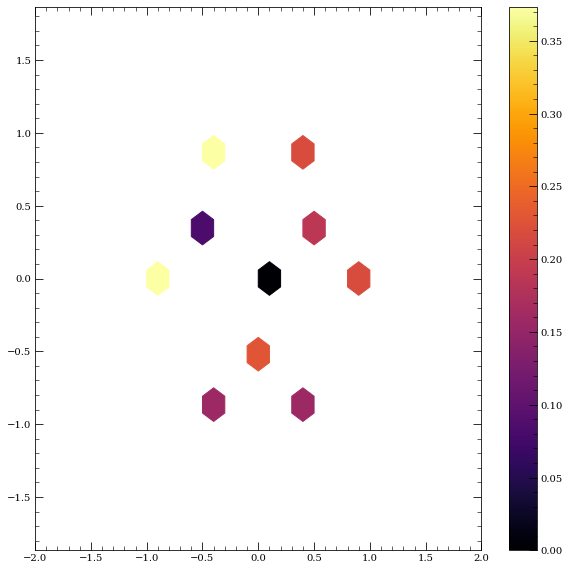

1.4142135623730951


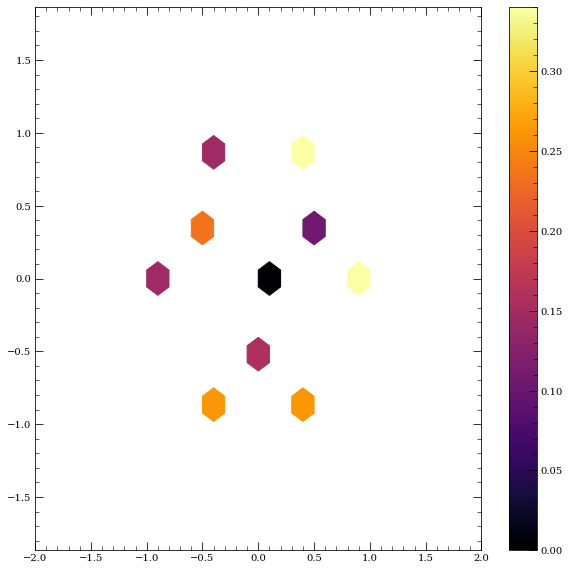

1.414213562373098


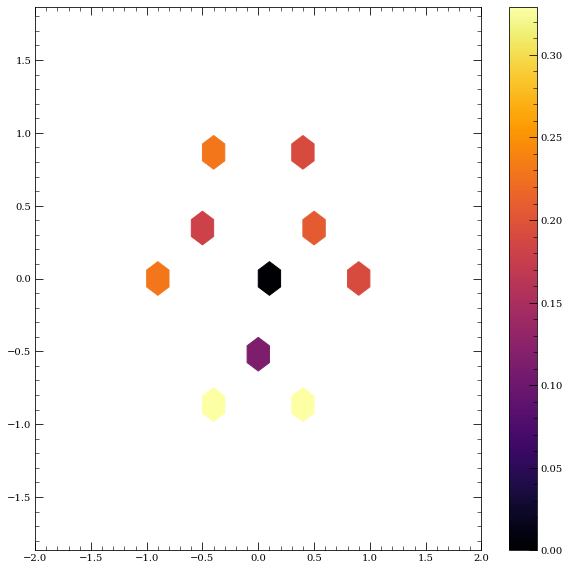

1.6606837081188752


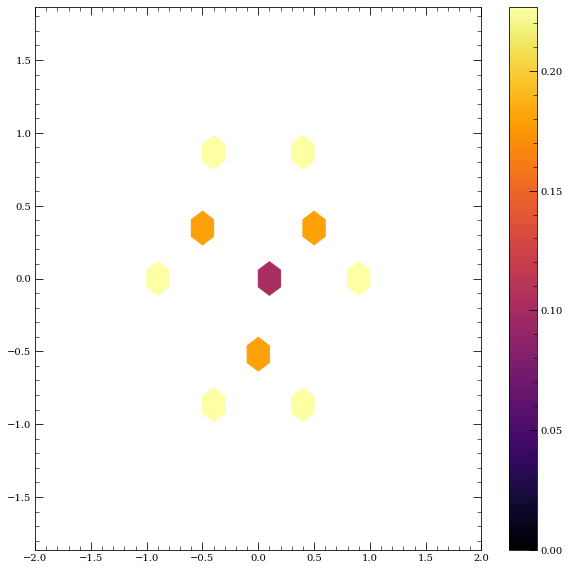

2.01557920428876


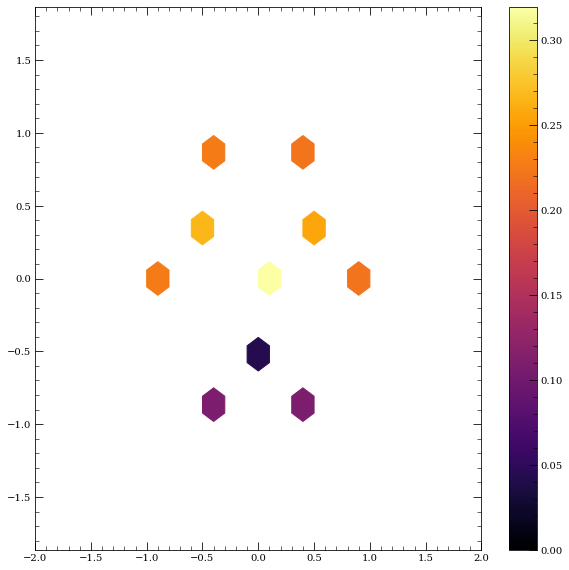

2.0155792042887652


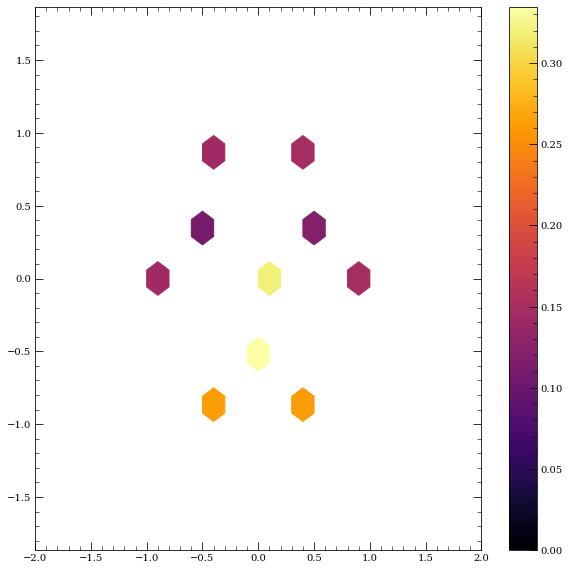

2.135779205069855


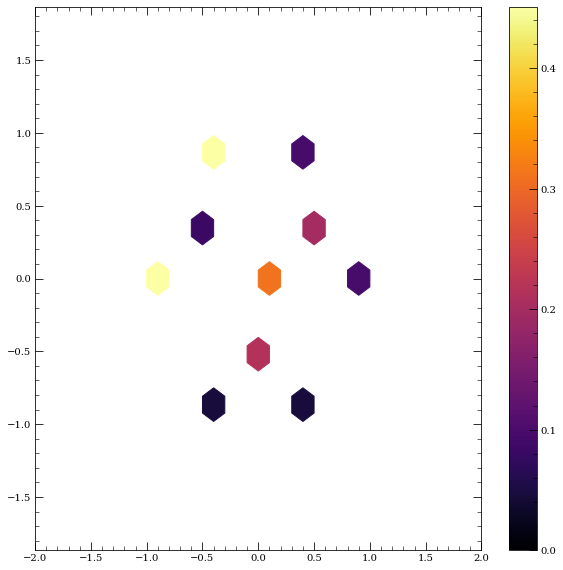

2.1357792050698556


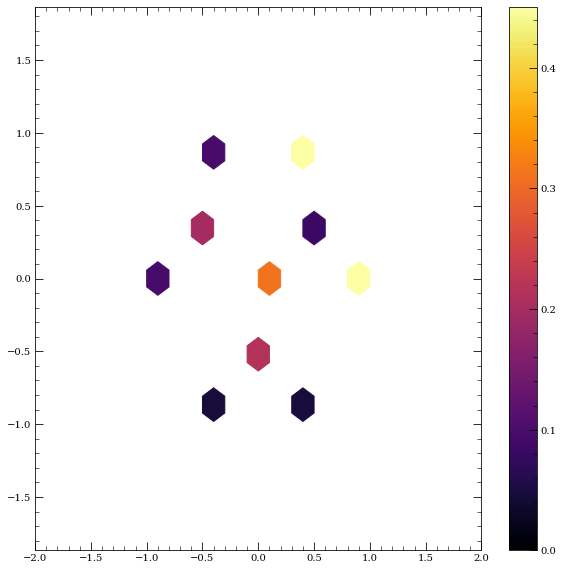

2.1357792050698605


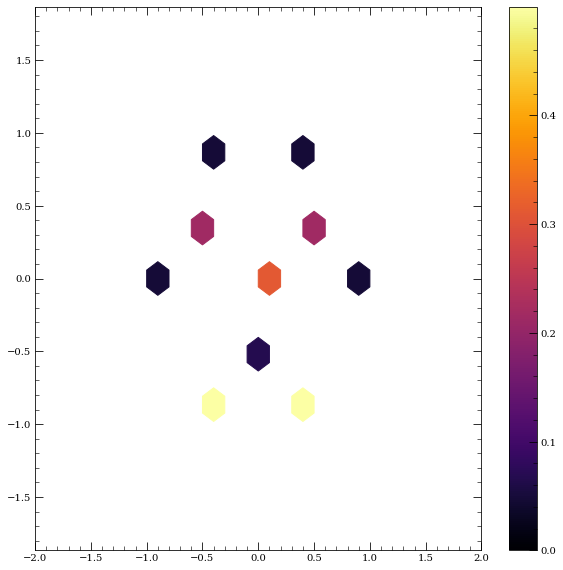

3.2208769184231083


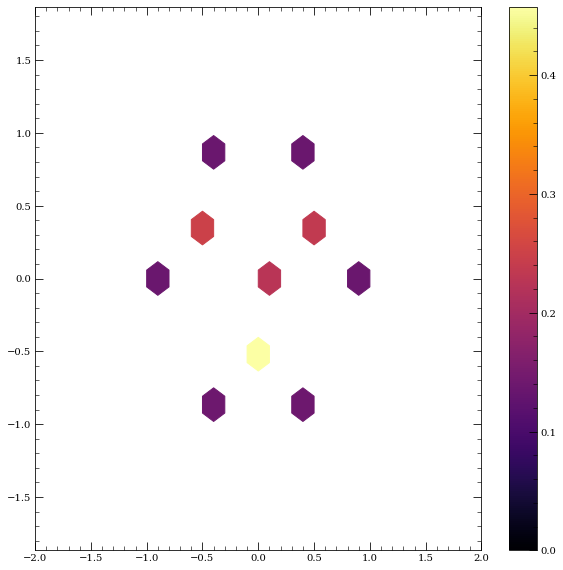

3.22087691842311


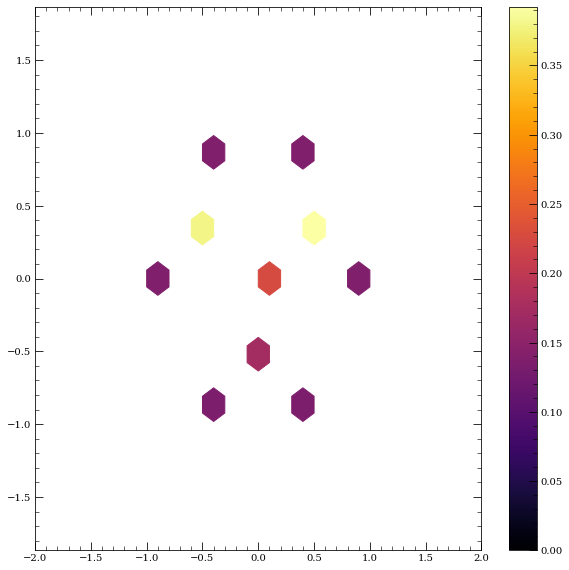

3.8287151965166086


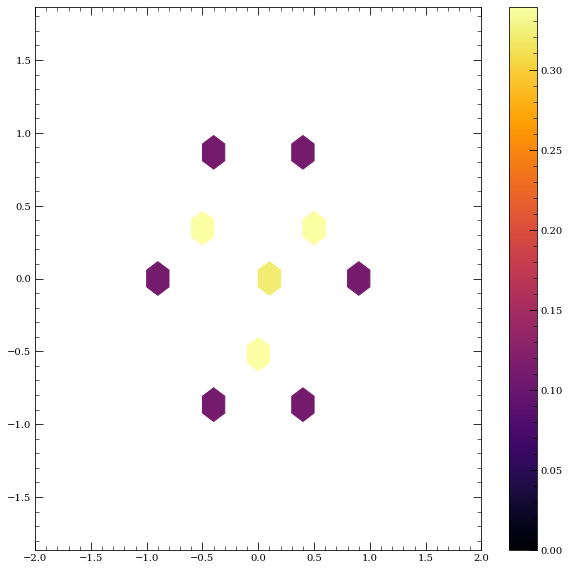

In [13]:
obs_basis=2
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)
eVals,eVecs,edge=findEigenVectors(eVecs,eVals,proj,nodes,True)

1 particle basis
2 particle basis
3 particle basis
4 particle basis
5 particle basis
6 particle basis
7 particle basis
8 particle basis
9 particle basis


<Figure size 1080x1440 with 0 Axes>

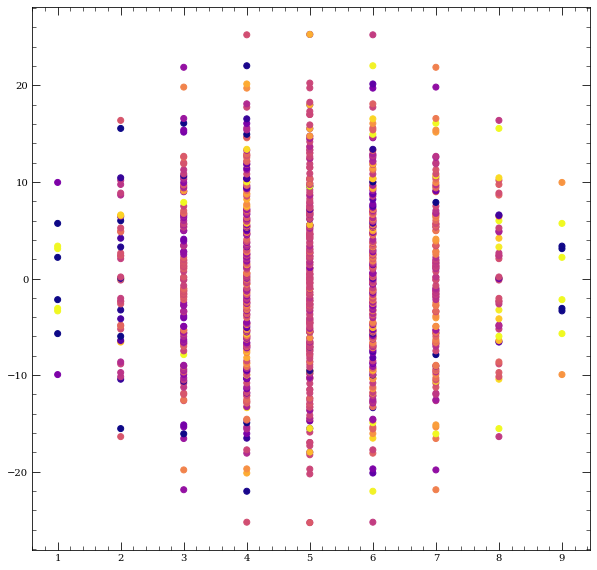

<Figure size 1080x1440 with 0 Axes>

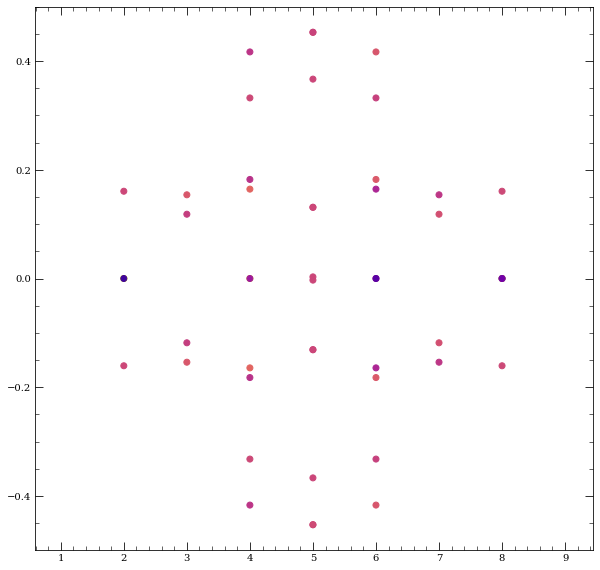

In [24]:
M=0
P=np.pi*1j
symm=True
sets=2
printEigenspectrum(M,P,1,1,1,symm,sets)

-3.8287151965166077


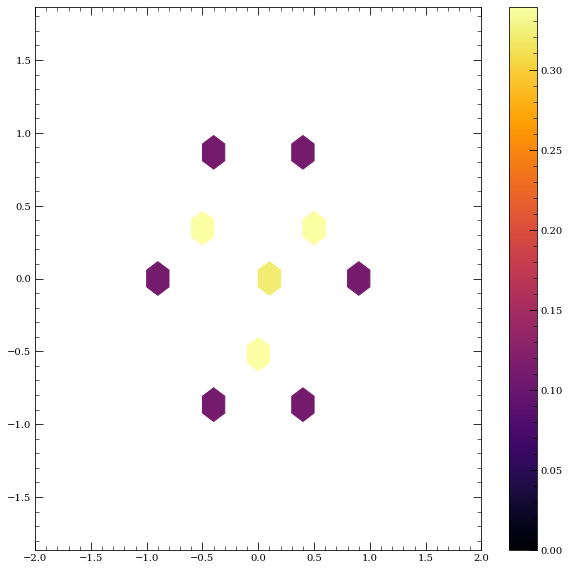

-3.220876918423111


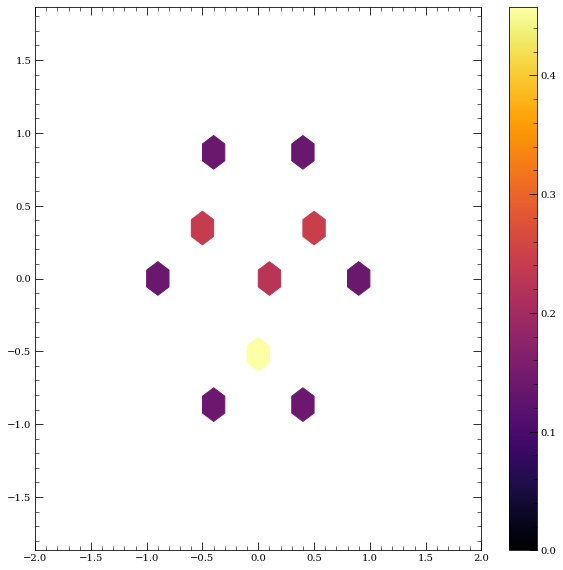

-3.2208769184231025


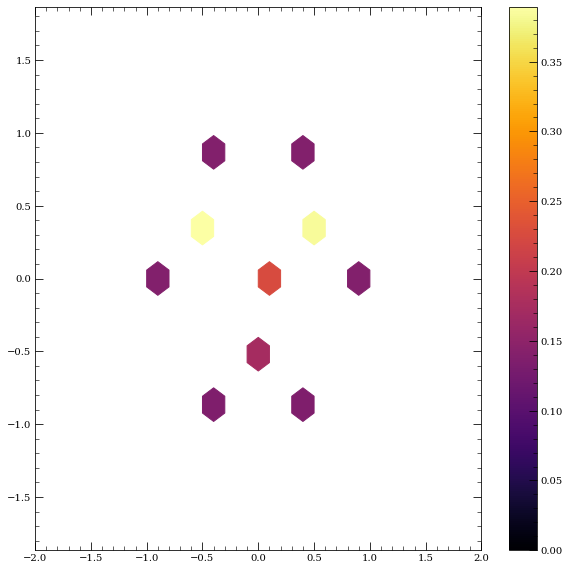

-2.135779205069858


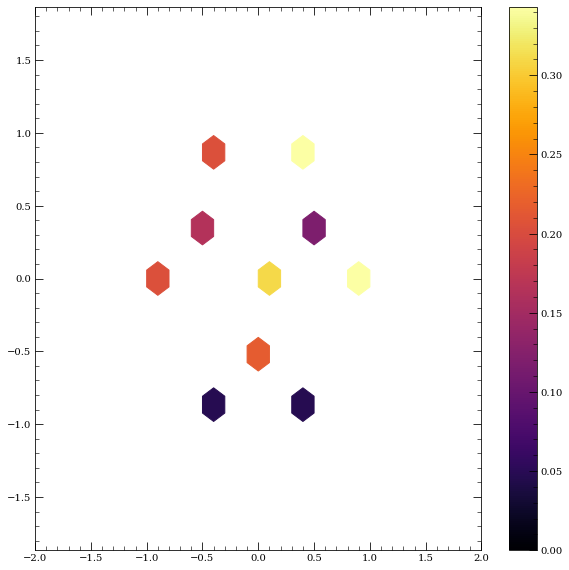

-2.1357792050698534


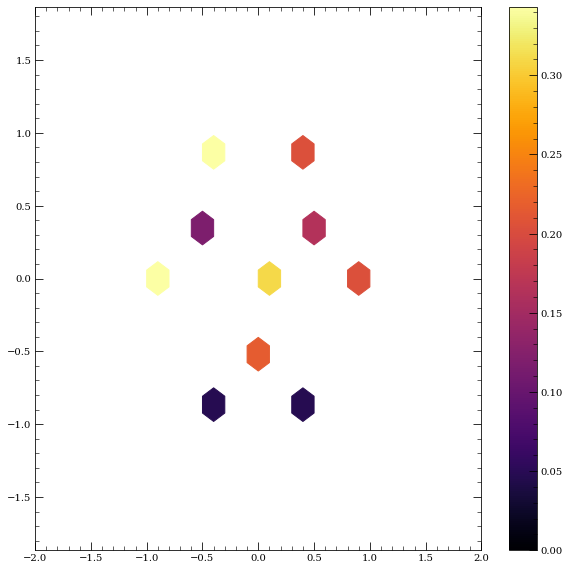

-2.1357792050698485


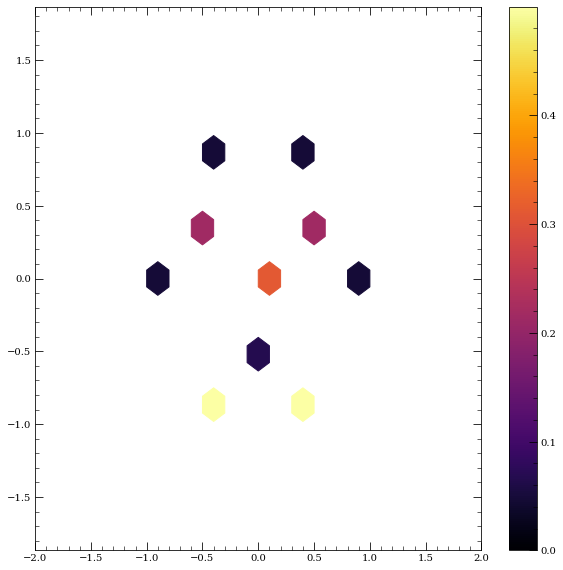

-2.01557920428876


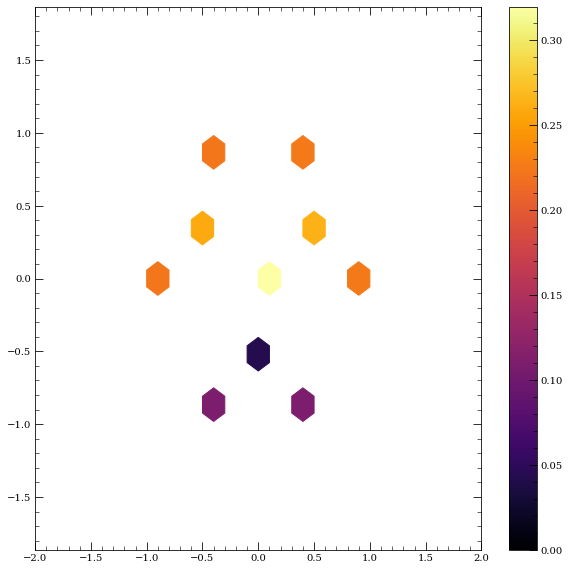

-2.0155792042887537


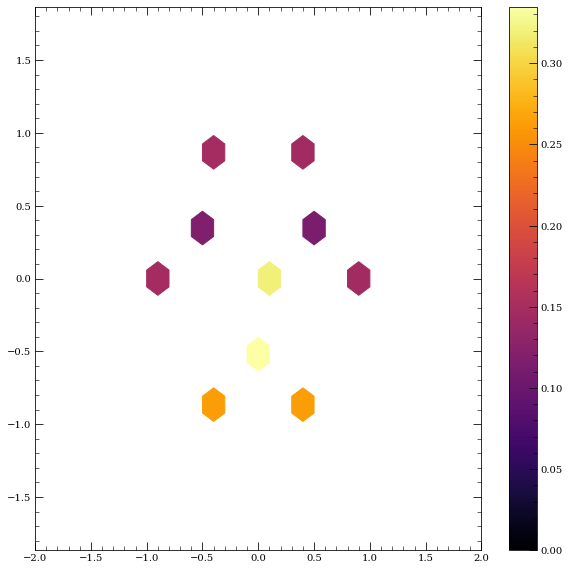

-1.6606837081188632


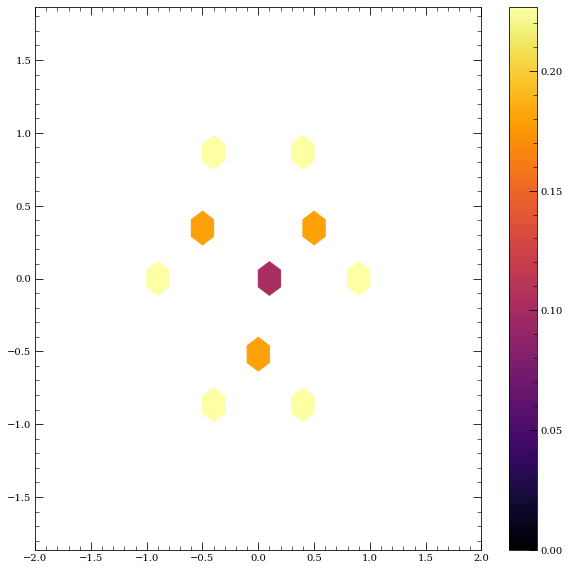

-1.4142135623730965


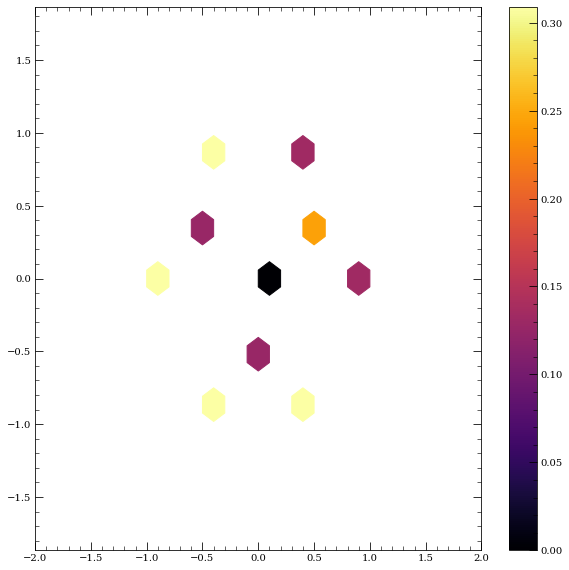

-1.4142135623730951


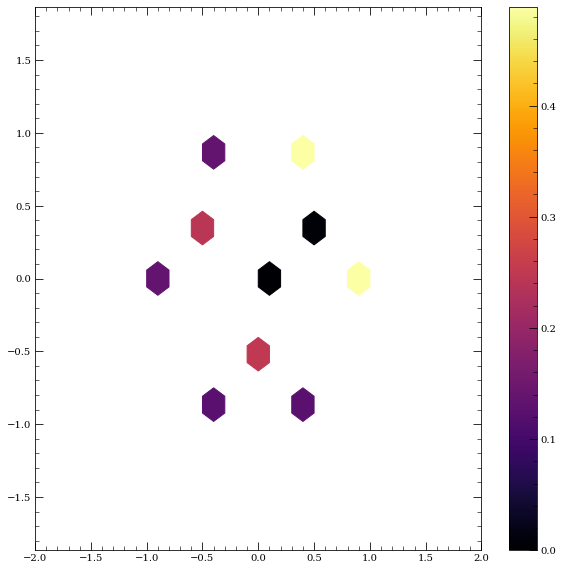

-1.4142135623730887


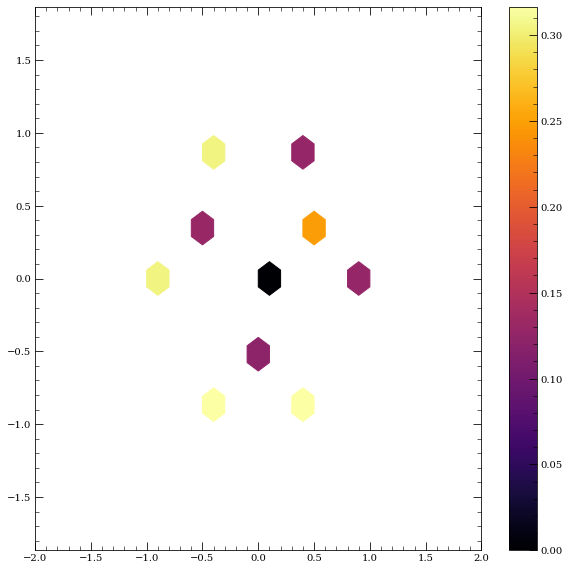

-1.2582009241577228


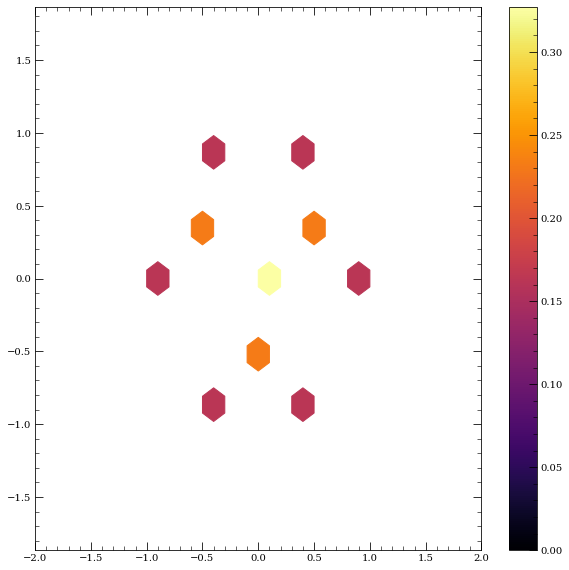

-1.163159258892663


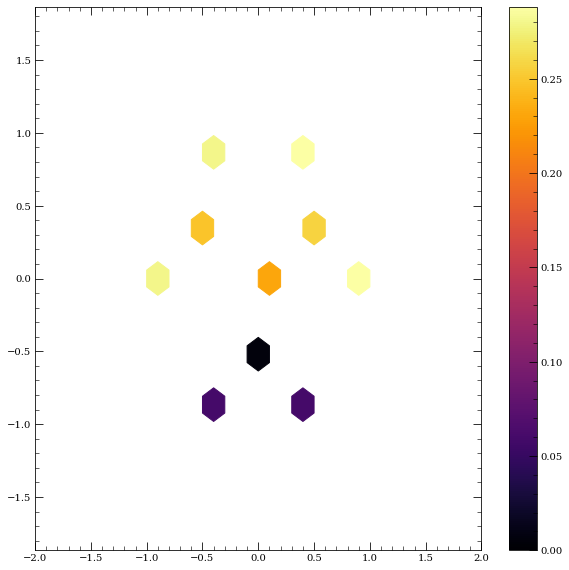

-1.1631592588926563


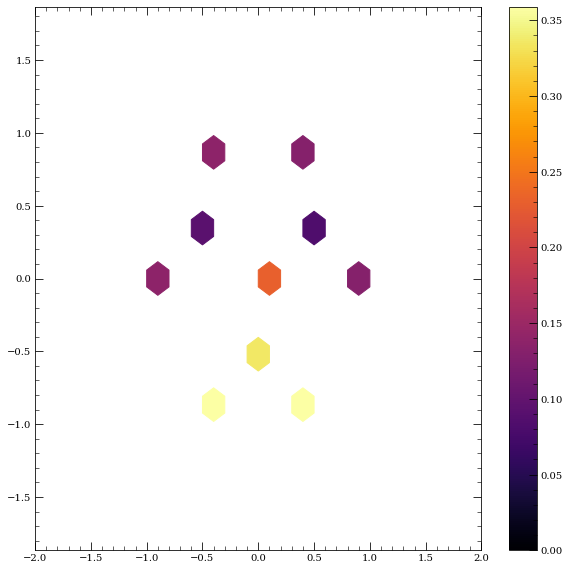

-0.6621534468619567


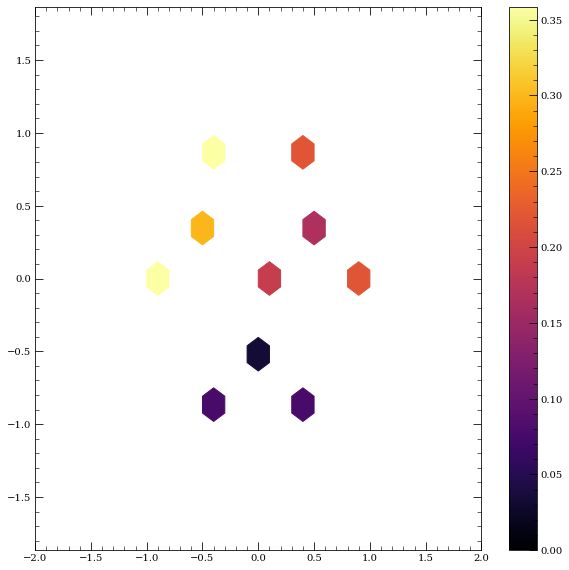

-0.6621534468619534


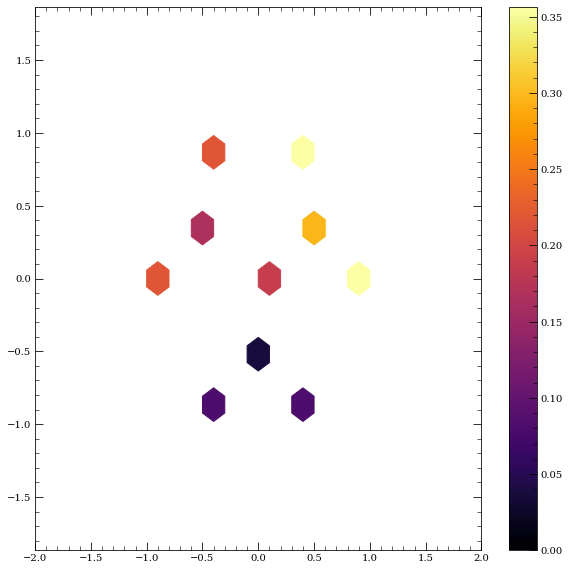

-0.6621534468619525


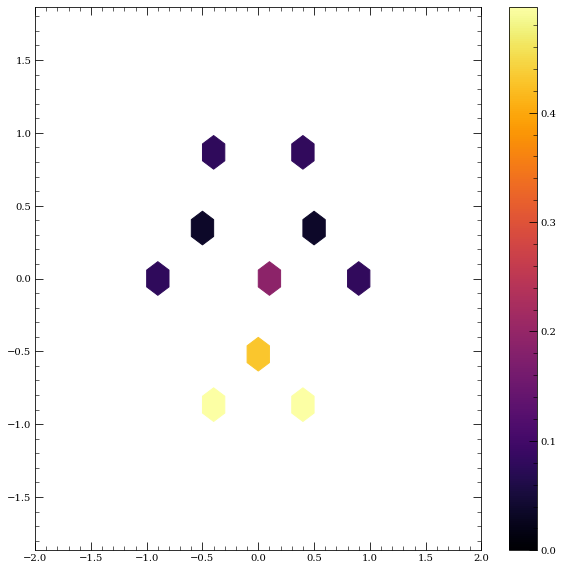

-0.4587514425701806


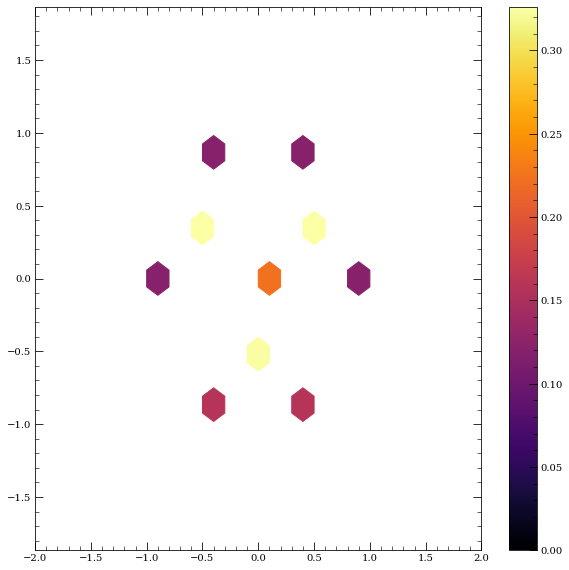

-0.45875144257017725


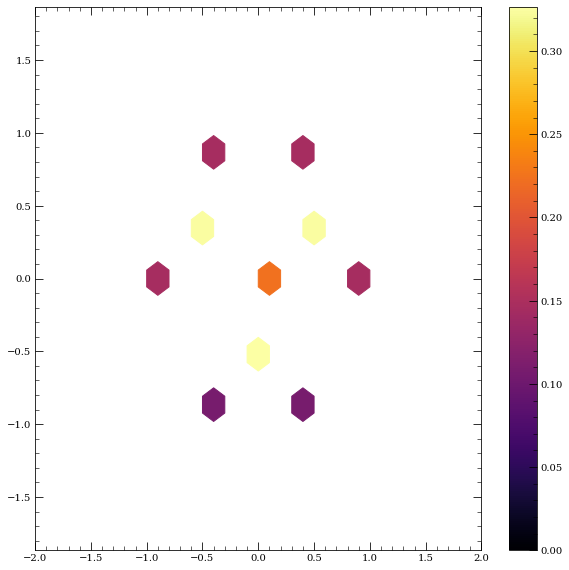

-1.7553332585808065e-16


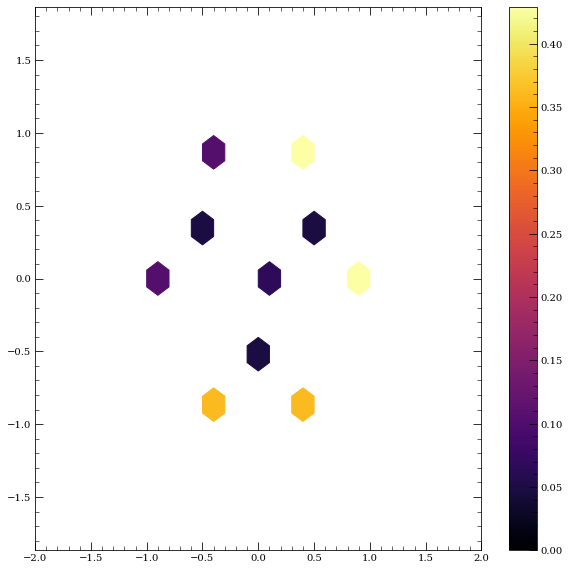

-7.103118882406812e-17


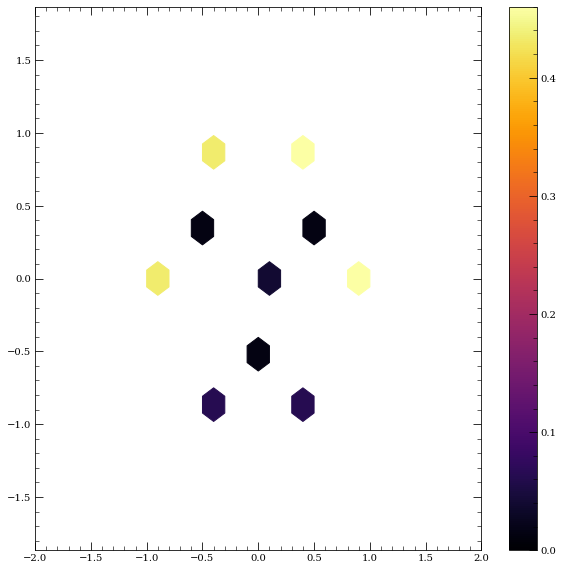

-1.0453036459140484e-17


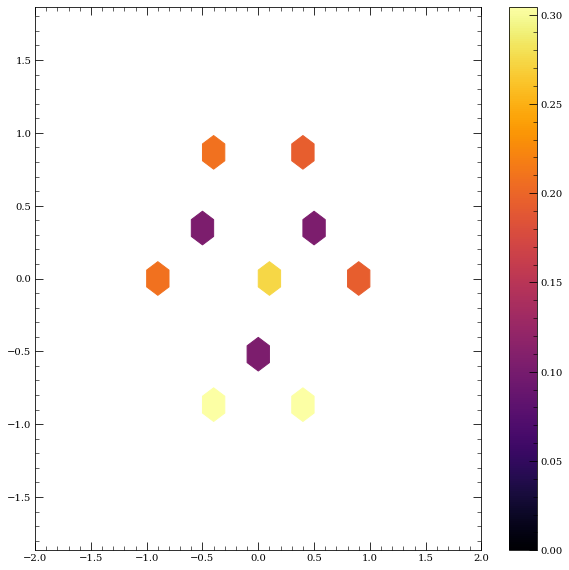

4.0810005826651253e-16


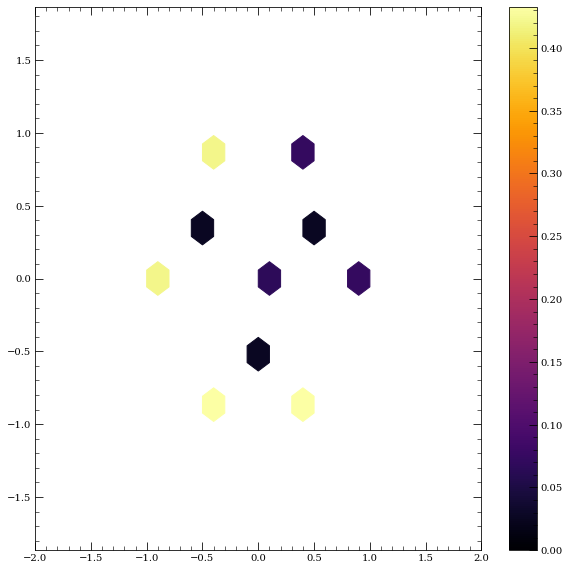

3.516326536847299e-15


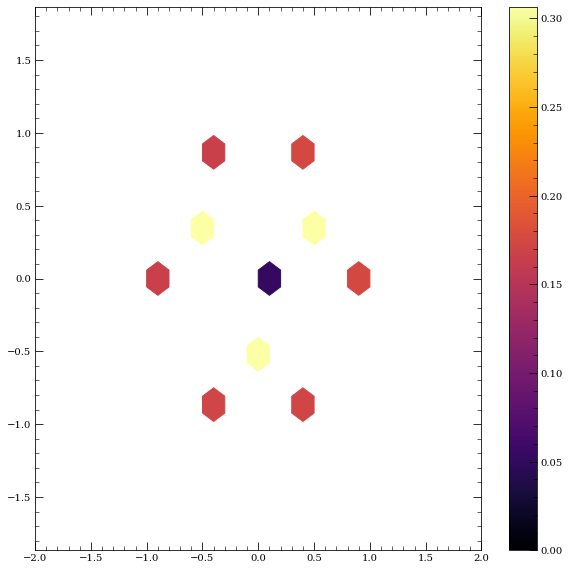

0.4587514425701753


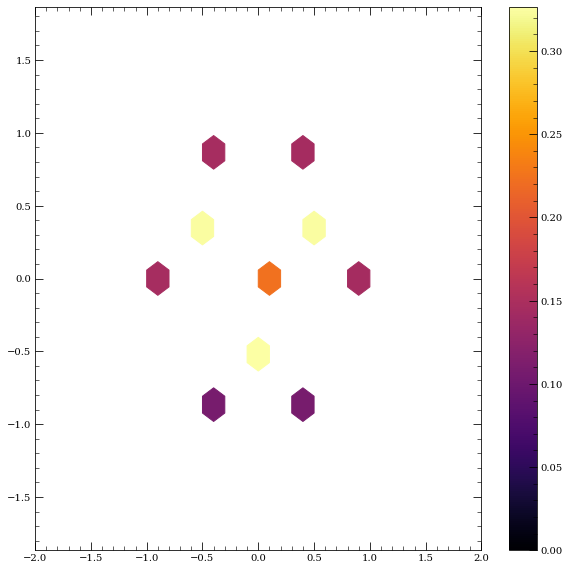

0.4587514425701812


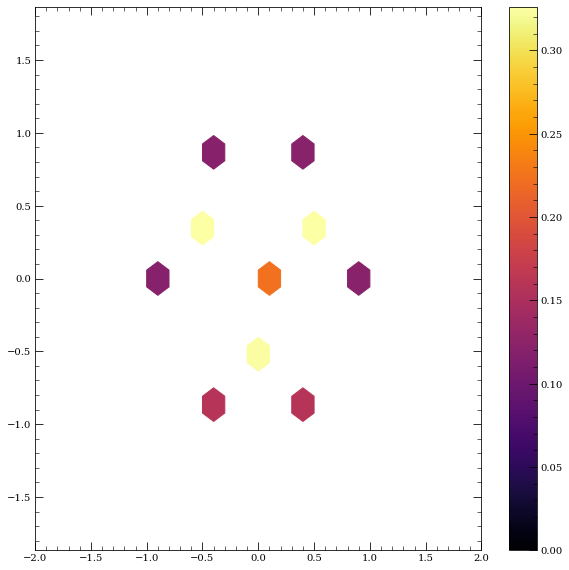

0.6621534468619578


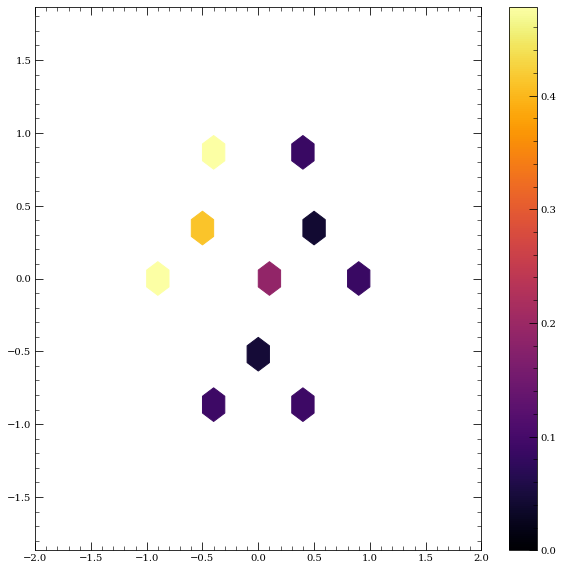

0.6621534468619579


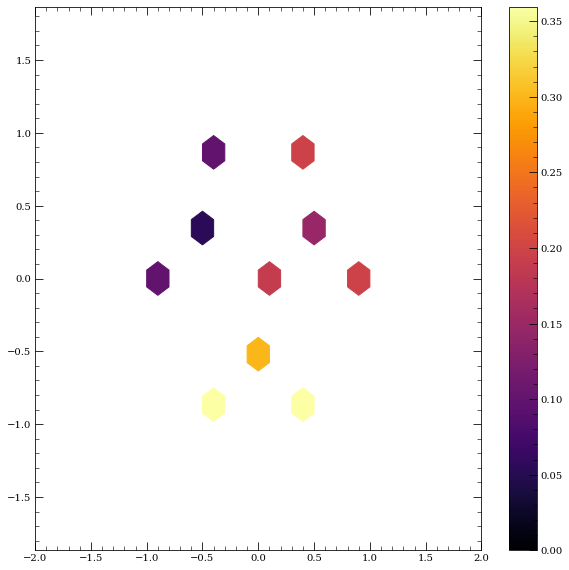

0.662153446861958


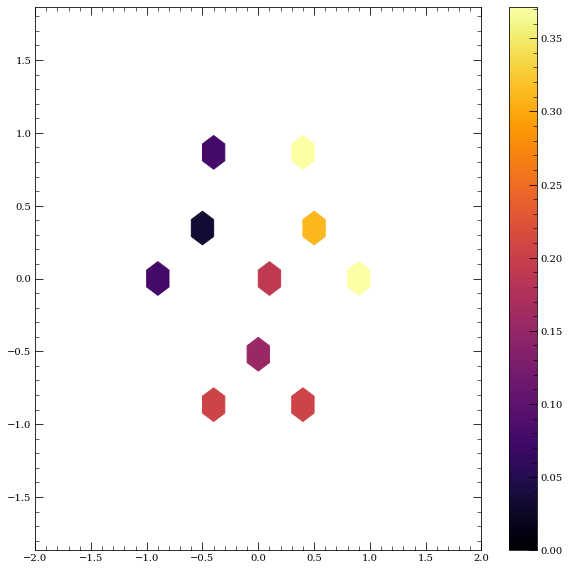

1.163159258892658


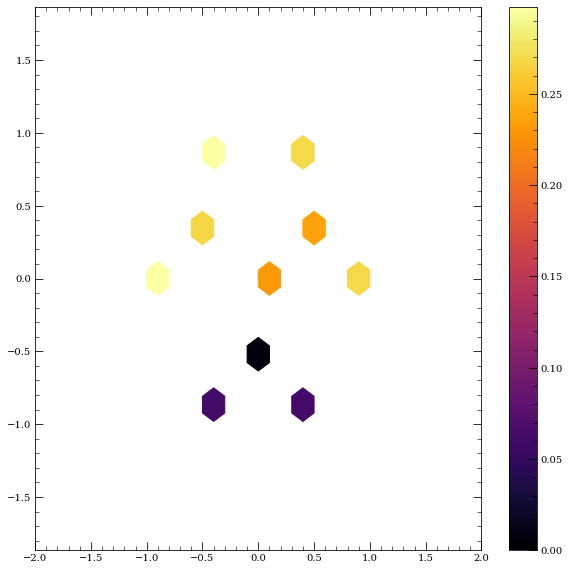

1.1631592588926616


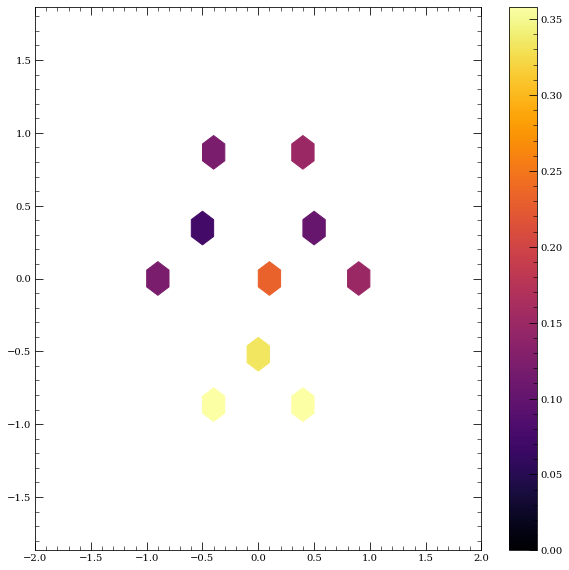

1.2582009241577192


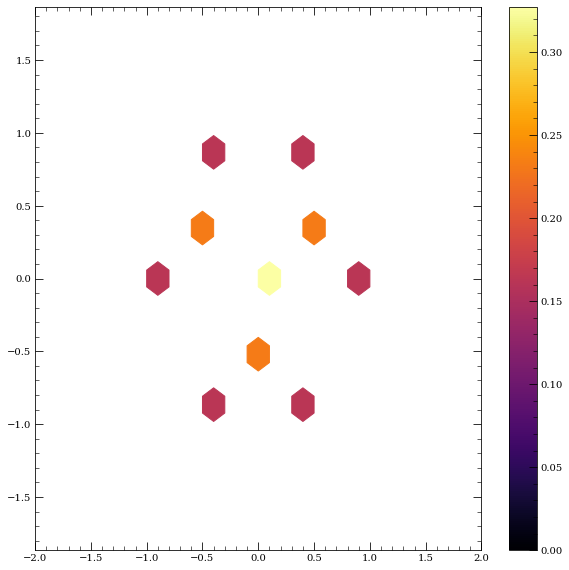

1.414213562373095


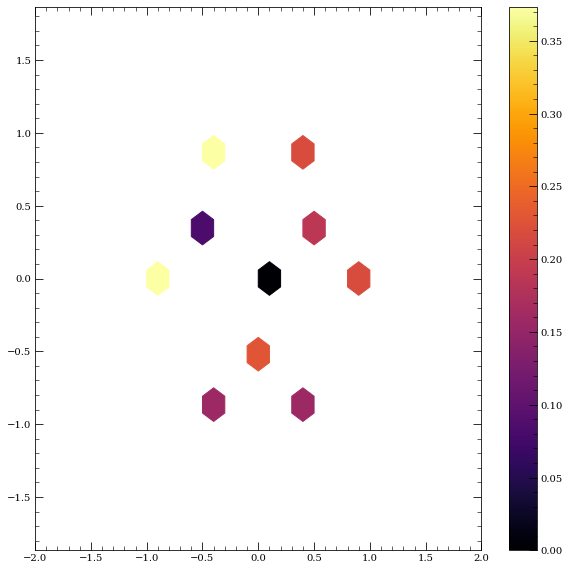

1.4142135623730951


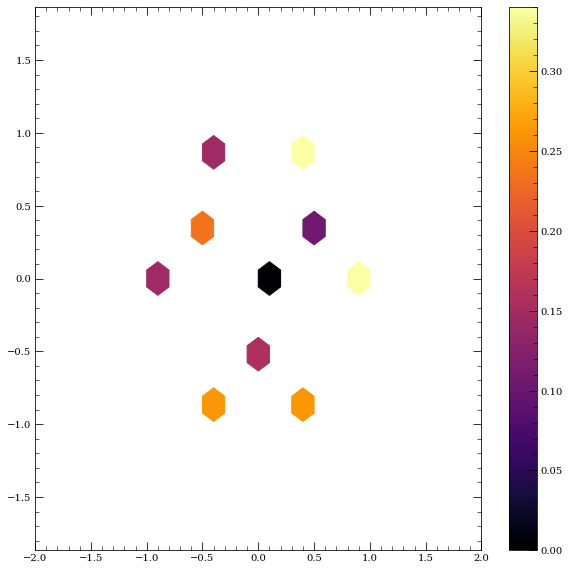

1.414213562373098


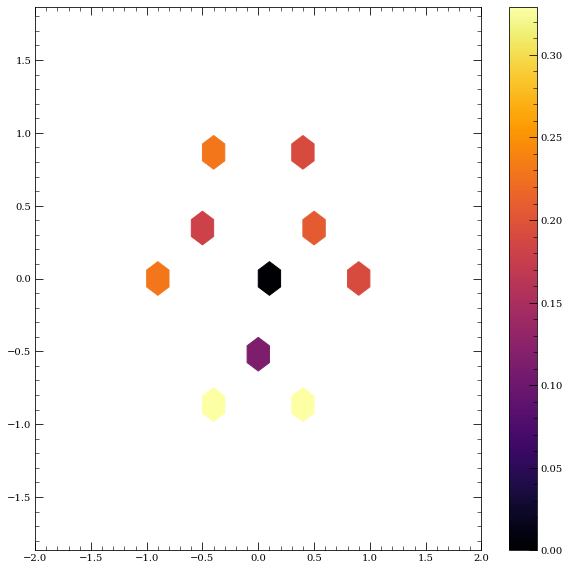

1.6606837081188752


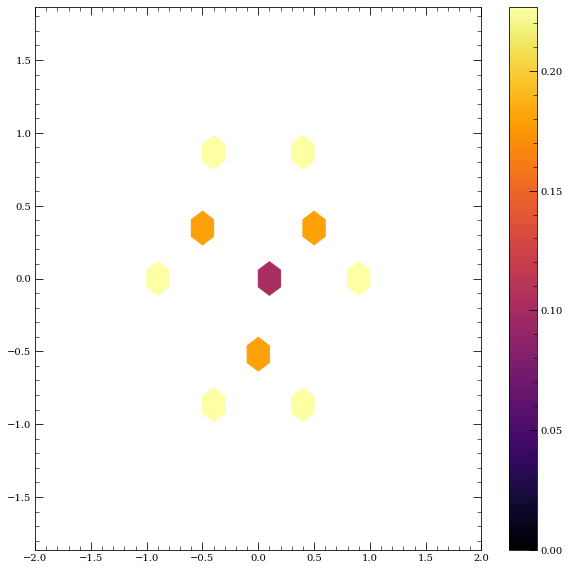

2.01557920428876


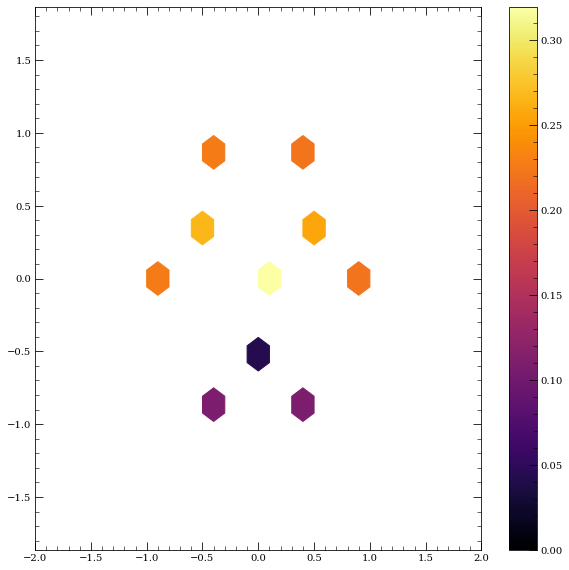

2.0155792042887652


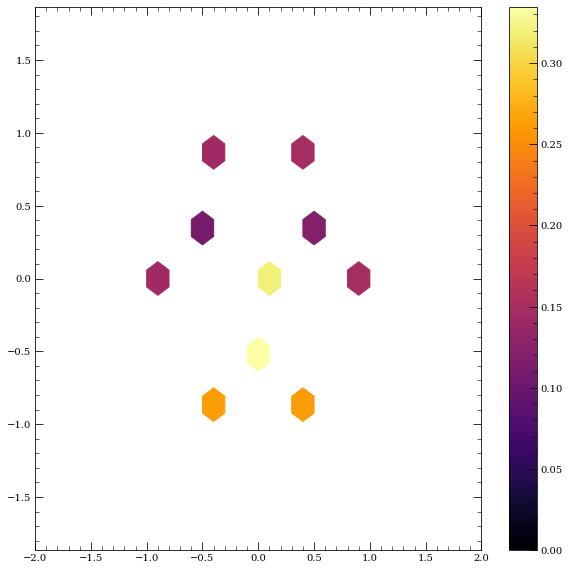

2.135779205069855


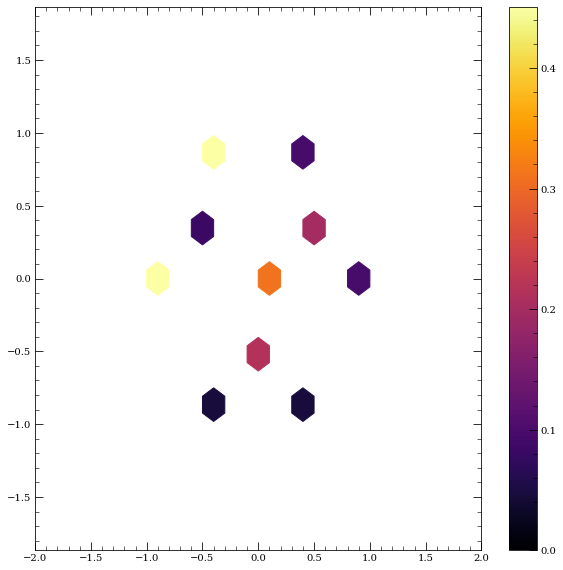

2.1357792050698556


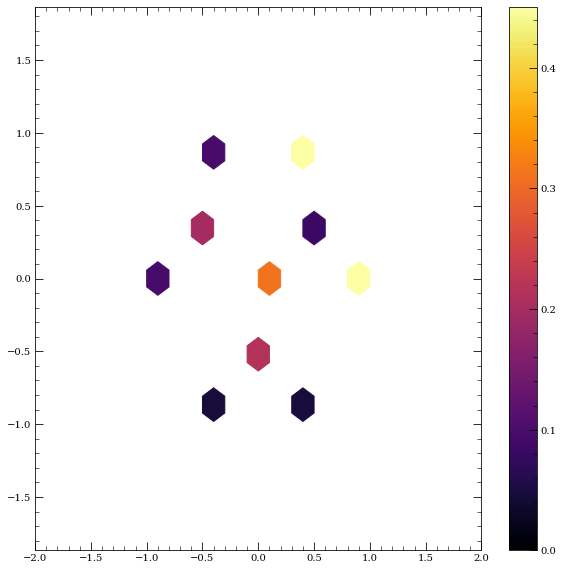

2.1357792050698605


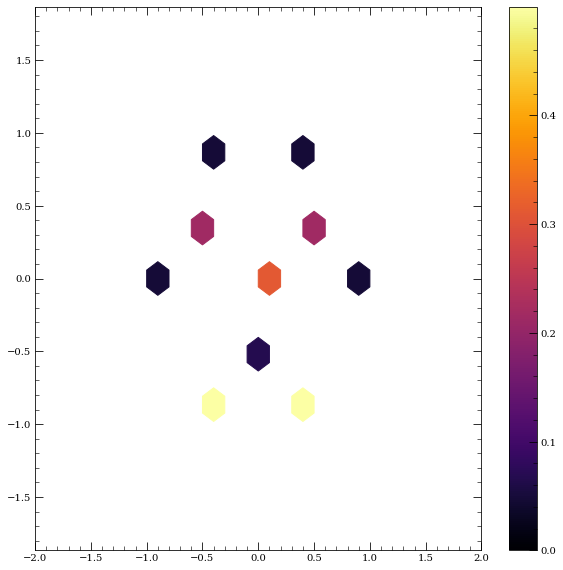

3.2208769184231083


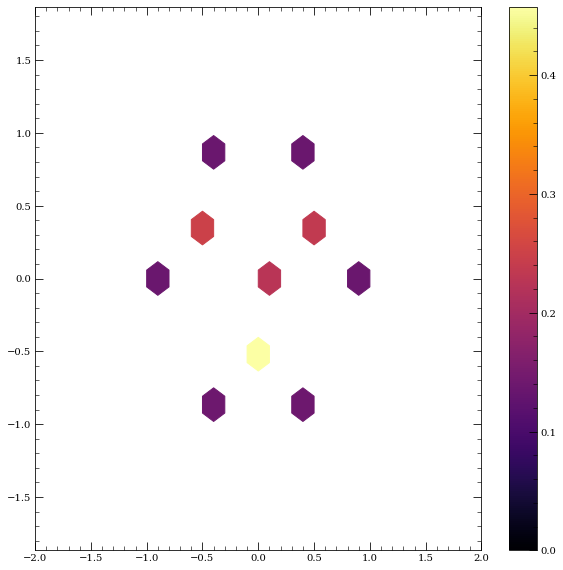

3.22087691842311


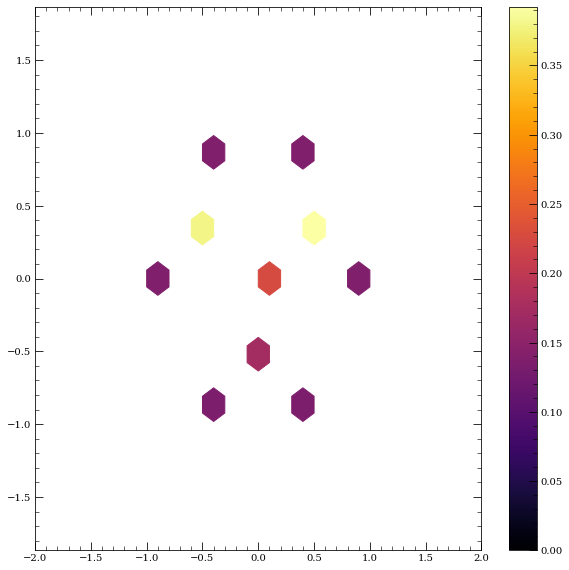

3.8287151965166086


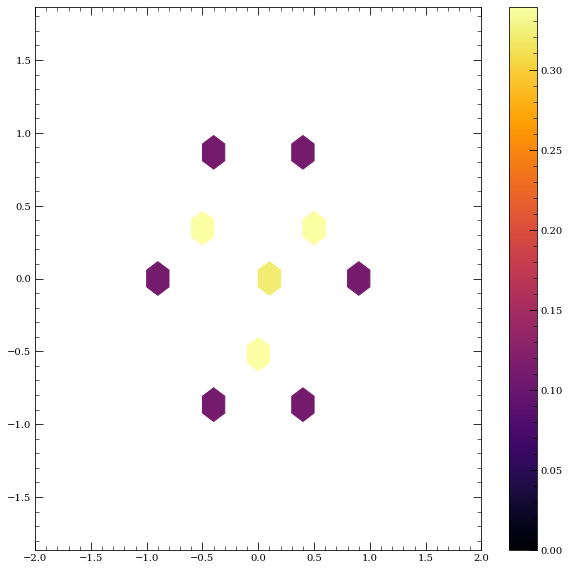

In [14]:
obs_basis=2
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)
eVals,eVecs,edge=findEigenVectors(eVecs,eVals,proj,nodes,True)

1 particle basis
2 particle basis
3 particle basis
4 particle basis
5 particle basis
6 particle basis
7 particle basis
8 particle basis
9 particle basis


<Figure size 1080x1440 with 0 Axes>

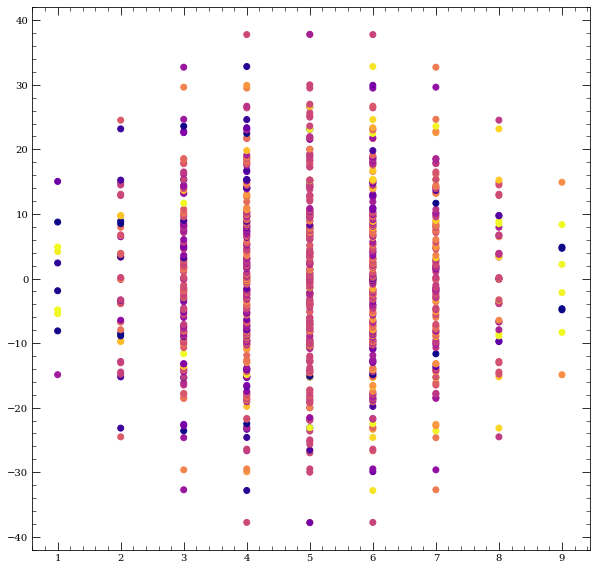

<Figure size 1080x1440 with 0 Axes>

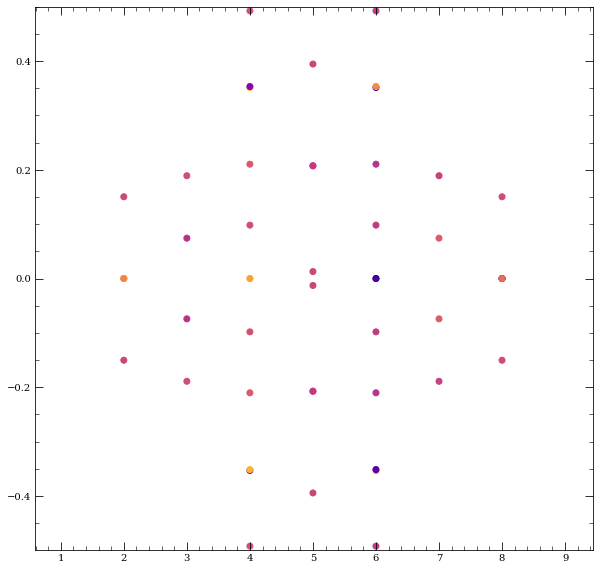

In [31]:
M=1
P=3*np.pi/2*1j
symm=True
sets=2
printEigenspectrum(M,P,1,1,1,symm,sets)

-14.897787809801798


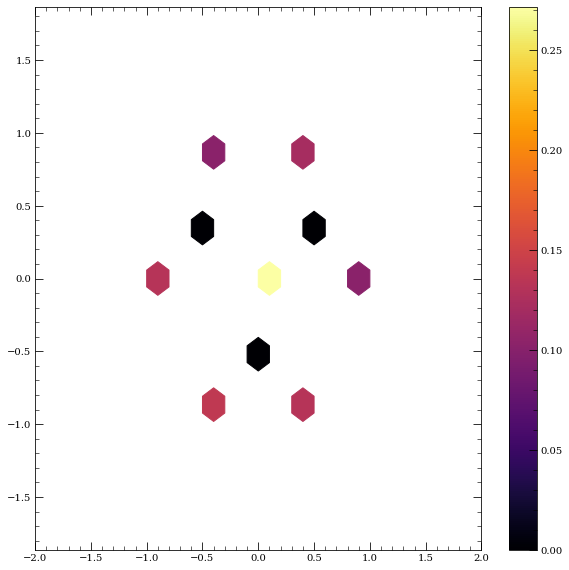

-8.112214713841766


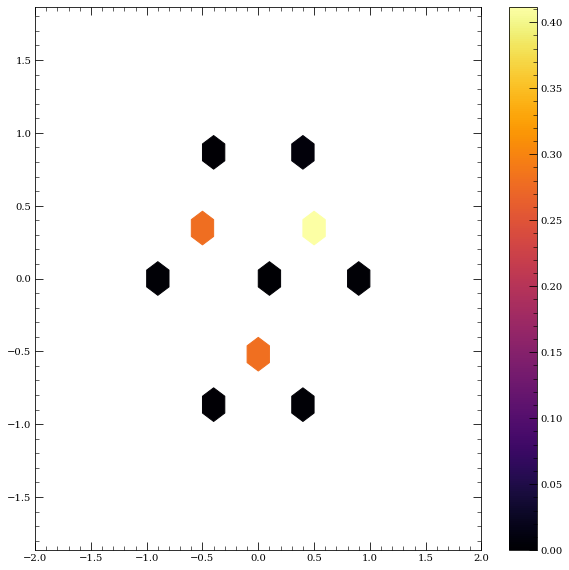

-5.460940332179909


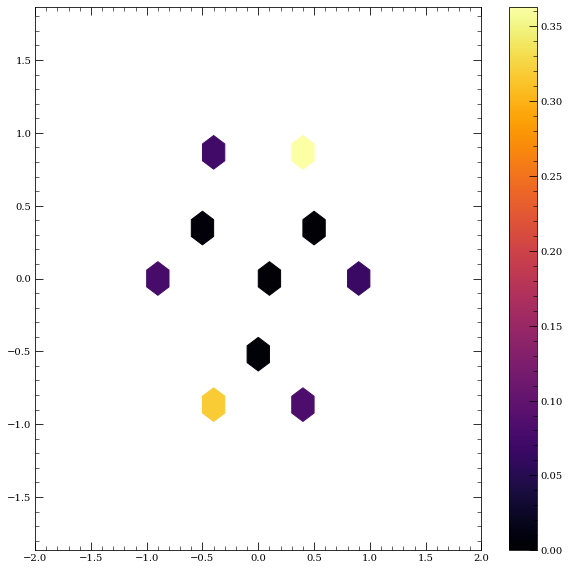

-4.857107330547116


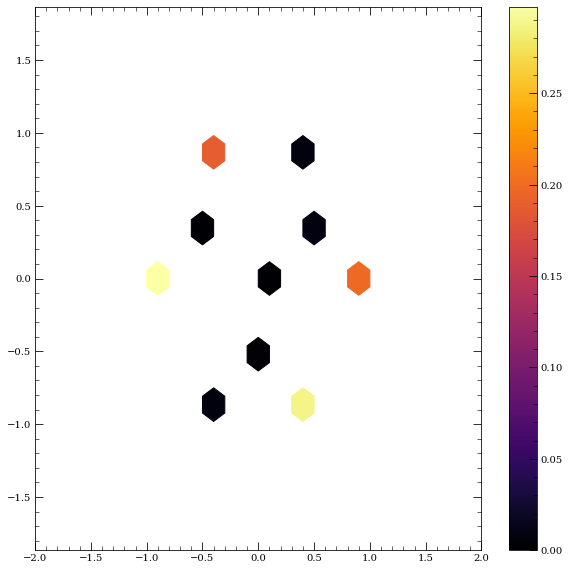

-1.8975416944393046


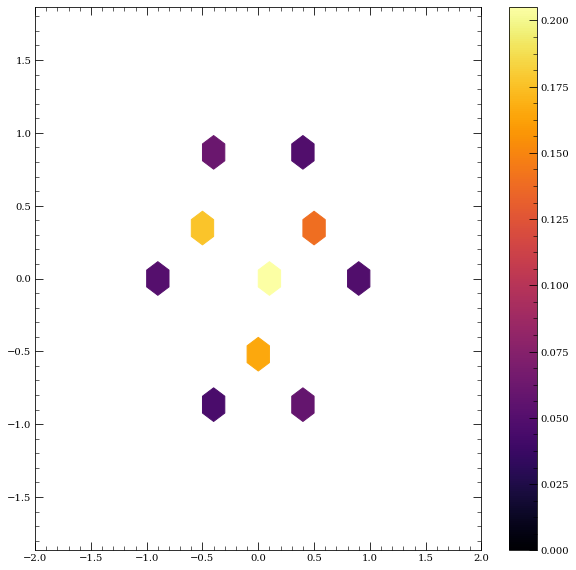

2.4061614922996544


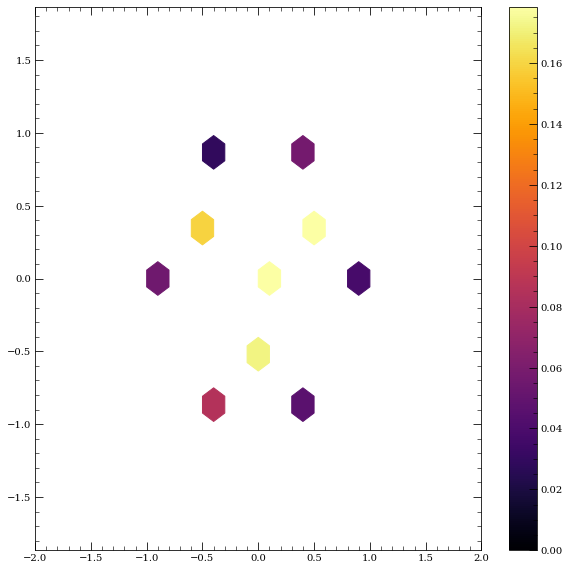

4.160568324023458


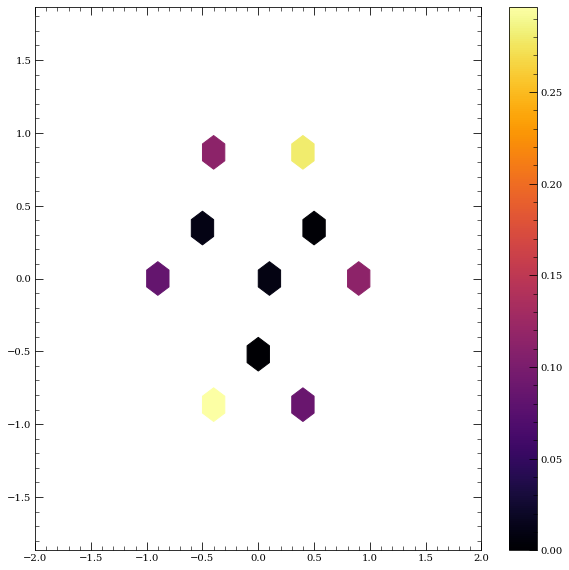

4.880598154461964


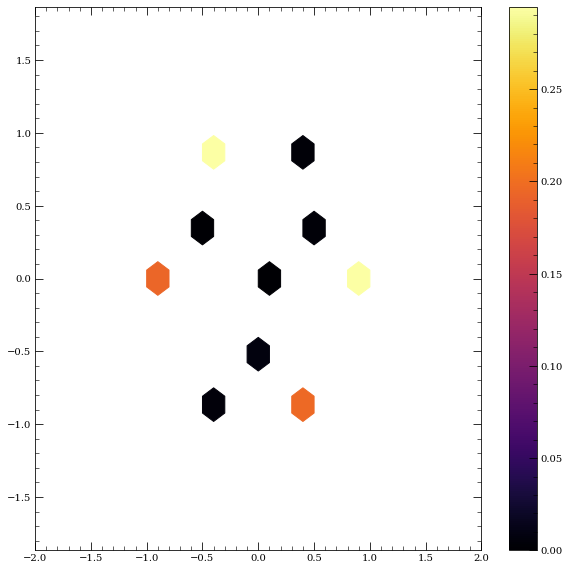

8.741985236845869


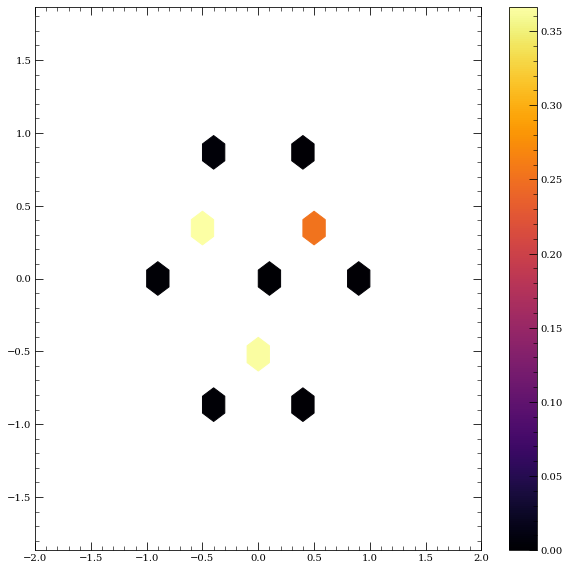

15.036278673179044


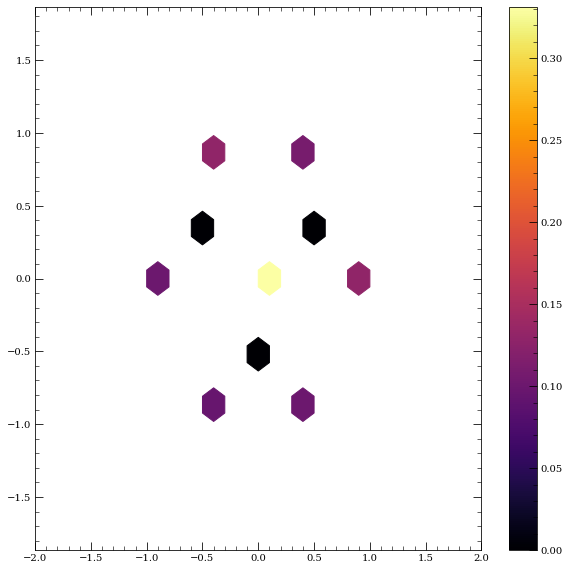

In [32]:
obs_basis=1
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)
eVals,eVecs,edge=findEigenVectors(eVecs,eVals,proj,nodes,True)

In [ ]:
M=1
P=3*np.pi/2*1j
symm=True
sets=3
printEigenspectrum(M,P,1,1,1,symm,sets)

1 particle basis
2 particle basis
3 particle basis
4 particle basis
5 particle basis
6 particle basis
